# Проект: Обучение с учителем: качество модели. Персонализация предложений постоянным клиентам интернет-магазина «В один клик».

__Заказчик исследования__: интернет-магазин "В один клик".

__Главная цель исследования__:  разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

__Данные для исследования__:
- _customer_behavior.csv_ (данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении)
- _customer_revenue.csv_ (данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом)
- _customer_engagement_time.csv_ (данные о времени (в минутах), которое покупатель провёл на сайте в течение периода)
- _customer_monthly_profit.csv_ (данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю)
    
__План проведения исследования__:
1. Промаркировать уровень финансовой активности постоянных покупателей: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
2. Собрать данные по клиентам по следующим группам:
    - коммуникация с клиентом;
    - продуктовое поведение покупателя (например, какие товары покупает и как часто);
    - финансовое поведение клиента(например, сколько тратил в магазине);
    - поведение покупателя на сайте(например, как много страниц просматривает и сколько времени проводит на сайте).
3. Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
4. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
5. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.
6. Подготовить общий вывод.

__Подготовка к исследованию__

Установка библиотек

In [ ]:
#!pip install -q phik

In [ ]:
#!pip install -q scikit-learn==1.1.3 

In [ ]:
#!pip install -q shap 

In [ ]:
#!pip install -q matplotlib==3.7.1

Импортирование необходимых библиотек и функций, прочие настройки

In [ ]:
import itertools
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns
import shap

from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# игнорирование всех UserWarning
warnings.filterwarnings("ignore", category=UserWarning)

# константы
# для однотипного отображения графиков
TITLE_SIZE = 18
LABEL_SIZE = 16
# для использования при работе с моделями
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка данных

Загрузим данные из csv-файлов.

In [ ]:
market_file = pd.read_csv('/datasets/customer_behavior.csv')

In [ ]:
market_money = pd.read_csv('/datasets/customer_revenue.csv')

In [ ]:
market_time = pd.read_csv('/datasets/customer_engagement_time.csv')

In [ ]:
money = pd.read_csv('/datasets/customer_monthly_profit.csv', sep=';', decimal=',')

Посмотрим на наши данные и убедимся, что они загрузились корректно и соответсвуют описанию.

In [12]:
def get_head_and_info(dataset):
    """
    Выводит первые 5 строк набора данных dataset
    и общую информацию о нем (через метод info()).
    """
    display(dataset.head())
    # не используем display чтобы не было None в последней строке
    dataset.info()

In [13]:
get_head_and_info(market_file)

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

__market_file__ содержит 1300 записей, пропусков нет, типы данных определены верно, присутствуют опечатки в категориальных данных, требуется переименование столбцов (не соблюдается змеиный регистр).

In [14]:
get_head_and_info(market_money)

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


__market_money__ содержит 3900 записей, пропусков нет, типы данных определены верно, необходимо проверить наличие опечаток в категориальных данных ('препредыдущий_месяц'), требуется переименование столбцов (названия должны начинаться со строчной буквы).

In [15]:
get_head_and_info(market_time)

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


__market_time__ содержит 2600 записей, пропусков нет, типы данных определены верно, присутствуют опечатки в категориальных данных, требуется переименование столбцов (названия должны начинаться со строчной буквы).

In [16]:
get_head_and_info(money)

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


__money__ содержит 1300 записей, пропусков нет, типы данных определены верно, присутствуют опечатки в категориальных данных, требуется переименование столбцов (названия должны начинаться со строчной буквы).

Содержимое всех наборов данных соответствуют описанию. Вместе с тем, стоит отметить следующее:
- в категориальных данных присутствуют опечатки, 
- требуется переименование стобцов.

__Вывод__:
- загрузили данные для исследования: market_file, market_money, market_time, money;
- убедились, что данные загрузились корректно и они соответствуют описанию, пропуски отсутствуют;
- заметили, что в категориальных данных присутствуют опечатки, а также требуется переименование стобцов (не соблюдается змеиный регистр).

## Предобработка данных

Переименуем столбцы, чтобы названия соотвествовали змеиному стилю.

In [17]:
def rename_columns(data):
    """"
    Функция выполняет цепочку преобразований для названия столбцов: удаляет лишние пробелы, 
    заменяет пробелы на "_", приводит к нижнему регистру, затем возращает датафрейм.
    """
    return data.rename(columns=lambda x: x.strip().replace(' ', '_').lower())

# Применение функции ко всем датафреймам
market_file = rename_columns(market_file)
market_money = rename_columns(market_money)
market_time = rename_columns(market_time)
money = rename_columns(money)

In [18]:
# создадим список с названиями датасетов
list_of_datasets = [market_file, market_money, market_time, money]

In [19]:
# проверка изменений
for dataset in list_of_datasets:
    dataset.info()
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

Проверим данные на наличие дубликатов.

In [20]:
for dataset in list_of_datasets:
    print(dataset.duplicated().sum())

0
0
0
0


In [21]:
def check_duplicates():
    """
    Функция для проверки наличия дубликатов по ключевый столбцам
    и вывода количества дубликатов в датасетах market_file, market_money, market_time, money.
    """
    # В датасете market_file для каждого покупателя должна существовать только одна запись.
    market_file_duplicate_id = market_file.duplicated(['id']).sum()
    print(f"Дубликаты в market_file: {market_file_duplicate_id}")

    # В датасете market_money для каждого покупателя должна существовать только одна запись за каждый период.
    market_money_duplicate_id_period = market_money.duplicated(['id', 'период']).sum()
    print(f"Дубликаты в market_money: {market_money_duplicate_id_period}")

    # В датасете market_time для каждого покупателя должна существовать только одна запись за каждый период.
    market_time_duplicate_id_period = market_time.duplicated(['id', 'период']).sum()
    print(f"Дубликаты в market_time: {market_time_duplicate_id_period}")

    # В датасете money для каждого покупателя должна существовать только одна запись.
    money_duplicate_id = money.duplicated(['id']).sum()
    print(f"Дубликаты в money: {money_duplicate_id}")

In [22]:
check_duplicates()

Дубликаты в market_file: 0
Дубликаты в market_money: 0
Дубликаты в market_time: 0
Дубликаты в money: 0


Явных дубликатов нет, поиск по ключевым столбцам также не выявил дубликатов. Но, как мы выяснили выше, есть проблемы с категориальными данными.

Приведем в порядок значения категориальных столбцов. Для этого будем получать список уникальных значений, выявлять ошибку и производить необходимую замену.

In [23]:
def explore_categorical_columns(data):
    """
    Функция для вывода количества уникальных значений для каждого категориального столбца в датасете data.
    """
    categorical_columns = data.select_dtypes(exclude=['number']).columns

    for col in categorical_columns:
        print(f"{data[col].value_counts()}")

In [24]:
explore_categorical_columns(market_file)

Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64
стандарт     914
премиум      376
стандартт     10
Name: тип_сервиса, dtype: int64
да     962
нет    338
Name: разрешить_сообщать, dtype: int64
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64


In [25]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт')

In [26]:
explore_categorical_columns(market_time)

текущий_месяц       1300
предыдцщий_месяц    1300
Name: период, dtype: int64


In [27]:
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

In [28]:
explore_categorical_columns(market_money)

предыдущий_месяц       1300
препредыдущий_месяц    1300
текущий_месяц          1300
Name: период, dtype: int64


In [29]:
# проверим, что в каждом из периодов присутствуют все id из market_file
market_money.groupby('период')['id'].apply(lambda x: set(x) == set(market_file['id']))

период
предыдущий_месяц       True
препредыдущий_месяц    True
текущий_месяц          True
Name: id, dtype: bool

In [30]:
# убедимся, что препредыдущий_месяц - не означает предыдущий_месяц
# если это опечатка, то после замены получим множество дублей
temp = market_money.copy()
temp['период'] = temp['период'].replace('препредыдущий_месяц', 'предыдущий_месяц')
temp.duplicated().sum()

5

Учитывая, что в датасете `market_file` есть 1300 уникальных `id`, а в `market_money` в каждом периоде также есть 1300 записей, для тех же 1300 `id`, считаем, что 'препредыдущий_месяц' - это обозначение отдельного прериода, а не опечатка.

Повторим поиск дубликатов по ключевым столбцам после изменений.

In [31]:
check_duplicates()

Дубликаты в market_file: 0
Дубликаты в market_money: 0
Дубликаты в market_time: 0
Дубликаты в money: 0


Дубликаты не обнаружены.

__Вывод__:
- привели названия столбцов в соответствие со змеиным стилем;
- выполнили предварительную проверку на явные дубликаты, а также проверку на дубликаты по ключевым столбцам;
- исправили опечатки в значениях категориальных столбцов;
- провели повторную проверку на дубликаты по ключевым столбцам, дубликаты не обнаружены. 

## Исследовательский анализ данных

Предварительно определим функции, которые будут полезны нам на текущем шаге.

In [32]:
def plot_pie_chart(data, title, column_to_plot, column_to_count):
    """
    Функция для построения круговой диаграммы по заданным данным.
    
    Параметры:
    data (DataFrame) : датасет
    title (str) : название диаграммы
    column_to_plot (str) : столбец, по которому строится диаграмма
    column_to_count (str) : столбец, по которому подсчитываются значения
    """
    counts_by_category = data.groupby(column_to_plot)[column_to_count].count()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = (
        counts_by_category
        .plot.pie(
            autopct=lambda p: '{:.1f}% ({:.0f})'.format(p, round(p * counts_by_category.sum() / 100)),
            legend=True,
            ylabel='',
            fontsize=14
        )
    )
    ax.set_title(title, fontsize=TITLE_SIZE)
    plt.show()

In [33]:
def create_pivot_table(data, columns_to_group, column_to_count):
    """
    Функция для создания сводной таблицы на основе данных из data,
    сгруппированных по столбцам columns_to_group и посчитанных по столбцу column_to_count.

    Параметры:
    data (DataFrame): датасет.
    columns_to_group (list): список названий столбцов для группировки данных.
    column_to_count (str): столбец, в котором нужно подсчитать количество вхождений.

    Возвращает:
    DataFrame: Сводная таблица с подсчетом количества и процентов для каждой группы.
    """
    pivot_table = data.pivot_table(
        index=columns_to_group,
        values=column_to_count,
        aggfunc='count'
    )

    pivot_table['процент'] = pivot_table.groupby(level=0).apply(lambda x: 100 * x / x.sum())
    pivot_table['процент'] = pivot_table['процент'].apply(lambda x: '{:.2f}%'.format(x))    
    return pivot_table

In [34]:
def analyze_numerical_data(data, column, title, bins_number=100):
    """
    Функция помогает при проведении статистического анализа количественных признаков.

    Принимает датасет, столбец для анализа и значение заголовка для вывода графика.
    Может принимать bins для построения графика.

    Выводит для колонки:
    - описание данных
    - гистограмму с отмеченным средним значением и медианой
    - диаграмму размаха
    """
     
    # получим описание данных
    print('\033[1m' + title + '\033[0m')
    display(data[column].describe())
    
    median = data[column].median()
    mean = data[column].mean()
        
    # Создаем фигуру и оси для гистограммы
    fig, ax = plt.subplots(2, 1, figsize=(17, 10))

    # Гистограмма
    ax[0].hist(data[column], bins=bins_number, color='skyblue')
    ax[0].set_title(title, fontsize=TITLE_SIZE)
    ax[0].set_xlabel(title, fontsize=LABEL_SIZE)
    ax[0].set_ylabel('Частота', fontsize=LABEL_SIZE)
    ax[0].grid(True)
    
    ax[0].axvline(median, color='green', linestyle='dashed', linewidth=1.5, label=f'Медиана: {median:.2f}')
    ax[0].axvline(mean, color='red', linestyle='dashed', linewidth=1.5, label=f'Среднее: {mean:.2f}')
    ax[0].legend()

    # Диаграмма размаха
    ax[1] = data[[column]].boxplot(vert=False, ax=ax[1])
    ax[1].set_title(f'Диаграмма размаха для признака "{title}"', fontsize=TITLE_SIZE)
    
    plt.tight_layout()
    # Установка вертикального отступа между графиками
    plt.subplots_adjust(hspace=0.3)
    plt.show()

In [35]:
def analyze_discrete_data(data, column, title):
    """
    Функция помогает при проведении статистического анализа дискретных численных признаков.

    Принимает датасет, столбец для анализа и значение заголовка для вывода графика.

    Выводит для колонки:
    - описание данных
    - график частот
    - диаграмму размаха
    """
     
    # получим описание данных
    print('\033[1m' + title + '\033[0m')
    display(data[column].describe())
    
    median = data[column].median()
    mean = data[column].mean()
        
    # Создаем фигуру и оси
    fig, ax = plt.subplots(2, 1, figsize=(17, 10))

    # График частот
    sns.countplot(x=data[column], ax=ax[0], palette='Blues')
    ax[0].set_title(title, fontsize=TITLE_SIZE)
    ax[0].set_xlabel(title, fontsize=LABEL_SIZE)
    ax[0].set_ylabel('Частота', fontsize=LABEL_SIZE)
    ax[0].grid(False)

    # Диаграмма размаха
    ax[1] = data[[column]].boxplot(vert=False, ax=ax[1])
    ax[1].set_title(f'Диаграмма размаха для признака "{title}"', fontsize=TITLE_SIZE)
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    plt.show()

Изучим предоставленные данные. 

Целевой признак - это рассчитанный класс покупательской активности.

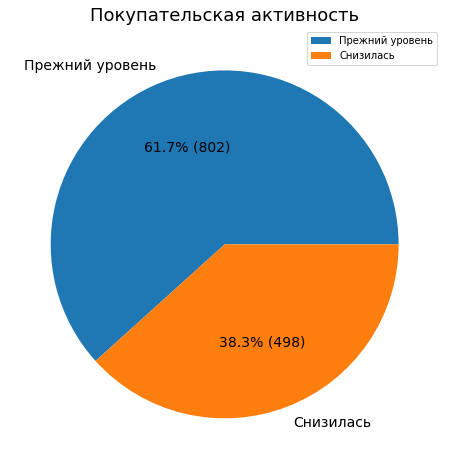

In [36]:
plot_pie_chart(market_file, 'Покупательская активность', 'покупательская_активность', 'id')

В предоставленном датасете наблюдаем, что активность 38.3% покупателей снизилась. Присутствует дисбаланс классов в целевой переменной. 

Первая группа признаков для изучения - __коммуникация с клиентом__:
- тип сервиса
- разрешение на сообщения
- маркетинг 6 месяцев
- маркетинг текущего месяца
- длительность истории с клиентом

Все признаки содержатся в датасете _market_file_.

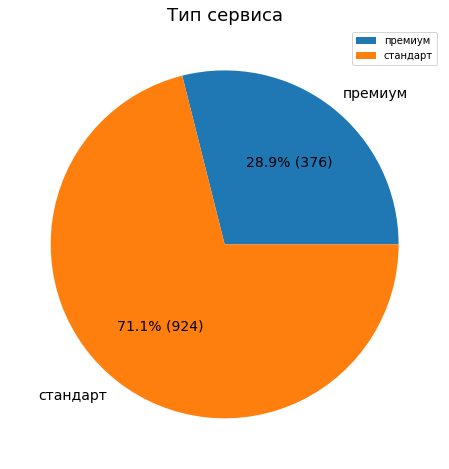

In [37]:
plot_pie_chart(market_file, 'Тип сервиса', 'тип_сервиса', 'id')

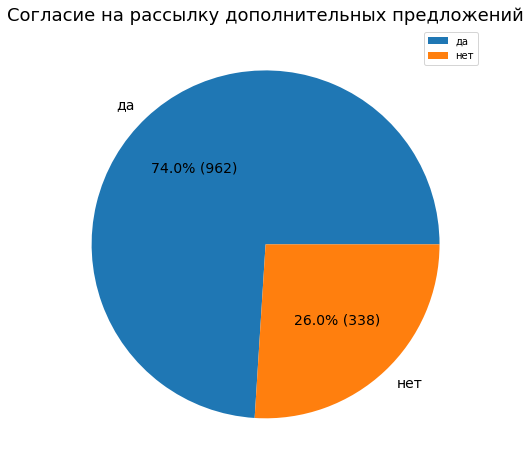

In [38]:
plot_pie_chart(market_file, 'Согласие на рассылку дополнительных предложений', 'разрешить_сообщать', 'id')

In [39]:
create_pivot_table(market_file, ['тип_сервиса', 'покупательская_активность'], 'id')

id процент
тип_сервиса покупательская_активность             
премиум     Прежний уровень            206  54.79%
            Снизилась                  170  45.21%
стандарт    Прежний уровень            596  64.50%
            Снизилась                  328  35.50%

In [40]:
create_pivot_table(market_file, ['разрешить_сообщать', 'покупательская_активность'], 'id')

id процент
разрешить_сообщать покупательская_активность             
да                 Прежний уровень            591  61.43%
                   Снизилась                  371  38.57%
нет                Прежний уровень            211  62.43%
                   Снизилась                  127  37.57%

In [41]:
create_pivot_table(market_file, ['тип_сервиса', 'разрешить_сообщать'], 'id')

id процент
тип_сервиса разрешить_сообщать             
премиум     да                  327  86.97%
            нет                  49  13.03%
стандарт    да                  635  68.72%
            нет                 289  31.28%

В предоставленных данных преобладают клиенты с уровнем обслуживания "стандарт" (71.1%). 74% покупателей дали согласие на рассылку дополнительных предложений. Вместе с тем, покупатели с уровнем обслуживания 'премиум' чаще соглашались на рассылку: 86.97% против 68.72%. Среди пользователей с уровнем обслуживания "стандарт" наблюдается снижение покупатьтельской активности у 35.5% покупателей, среди пользователей с уровнем обслуживания "премиум" - 45.21%. Снижение уровня покупательской активности среди тех, кто получает уведомления о новых предложениях, и тех, кто от них отказался, практически одинаковый - 38.57% и 37.57%. 

Среднемесячное значение маркетинговых коммуникаций за 6 месяцев


count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64

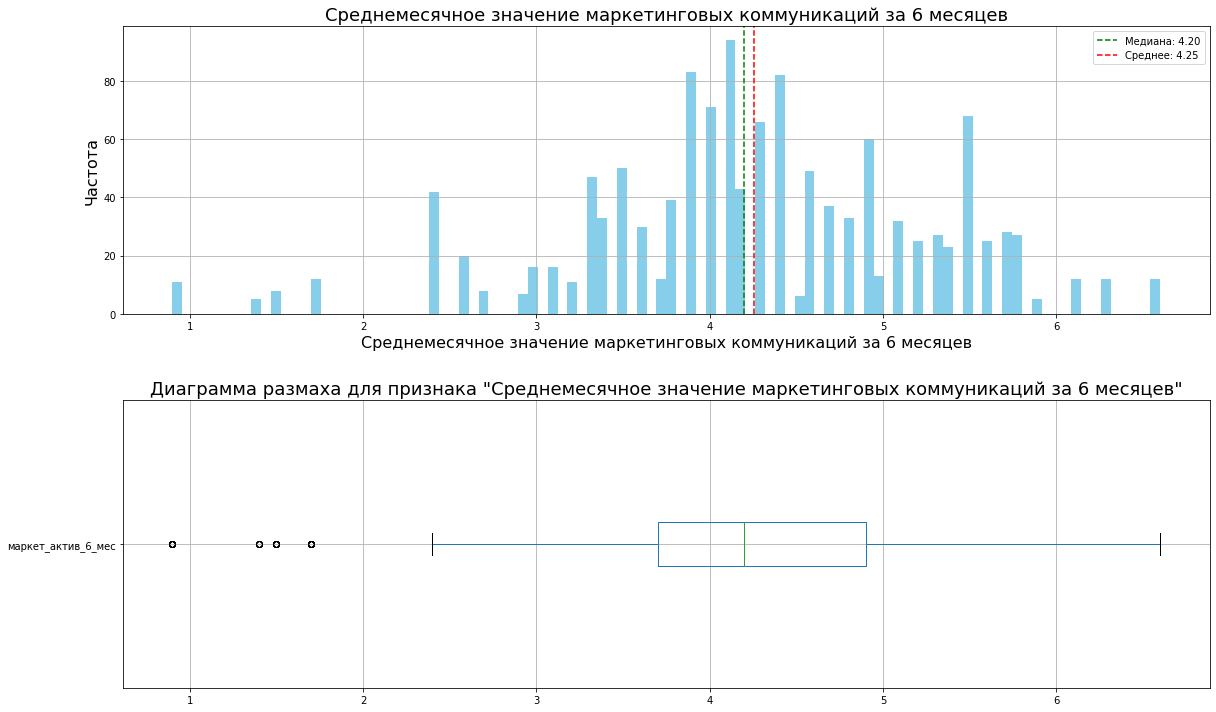

In [42]:
analyze_numerical_data(
    market_file, 'маркет_актив_6_мес', 'Среднемесячное значение маркетинговых коммуникаций за 6 месяцев')

In [43]:
market_file[market_file['маркет_актив_6_мес'] < 2]['маркет_актив_6_мес'].count()

36

In [44]:
market_file[market_file['маркет_актив_6_мес'] < 2]['покупательская_активность'].value_counts()

Снизилась          34
Прежний уровень     2
Name: покупательская_активность, dtype: int64

Значения признака "маркет_актив\_6\_мес" распределены в диапазоне от 0.9 до 6.6. Медианное значение - 4.2, среднее довольно близко к медианному - 4.25. Стандартное отклонение - 1.01. Границы межквартильного размаха - от 3.7 до 4.9. Часть наблюдений (36 значений) опредлена как выбросы (меньше 2 маркетинговых коммуникаций за 6 месяцев). Вместе с тем, эти значения не являются аномальными, оставим их. К тому же, если рассмотреть их вместе с целевым признаком, почти у всех покупателей наблюдалось снижение покупательской активности.

In [45]:
market_file['маркет_актив_тек_мес'].describe()

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64

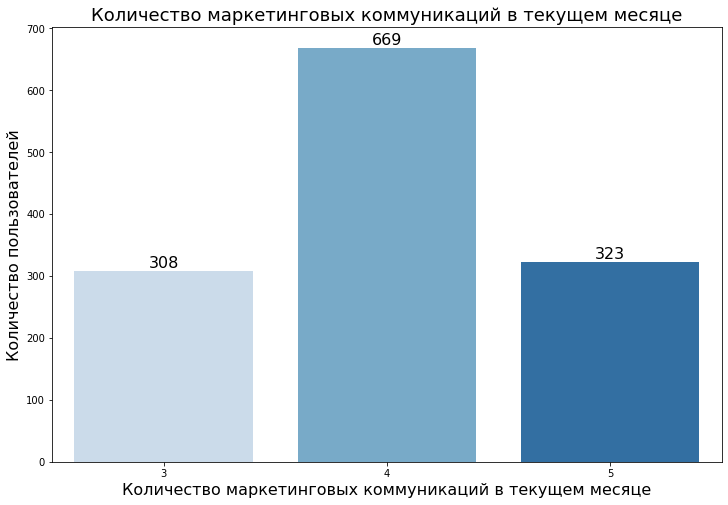

In [46]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(x=market_file['маркет_актив_тек_мес'], ax=ax, palette='Blues')
ax.set_title('Количество маркетинговых коммуникаций в текущем месяце', fontsize=TITLE_SIZE)
ax.set_xlabel('Количество маркетинговых коммуникаций в текущем месяце', fontsize=LABEL_SIZE)
ax.set_ylabel('Количество пользователей', fontsize=LABEL_SIZE)
ax.grid(False)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=LABEL_SIZE)
    
plt.show()

Количество маркетинговых коммуникаций в текущем месяце лежит в диапазоне от 3 до 5, более половины значений - 4 взаимодействия (межквартильный размах - от 4 до 4), мода и медиана равны 4, среднее взначение - 4.01, стандартное отклонение - 0.7. Учитывая небольшой разброс, можно говорить о стабильности коммуникаций в текущем месяце. 

Количество дней с момента регистрации пользователя


count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64

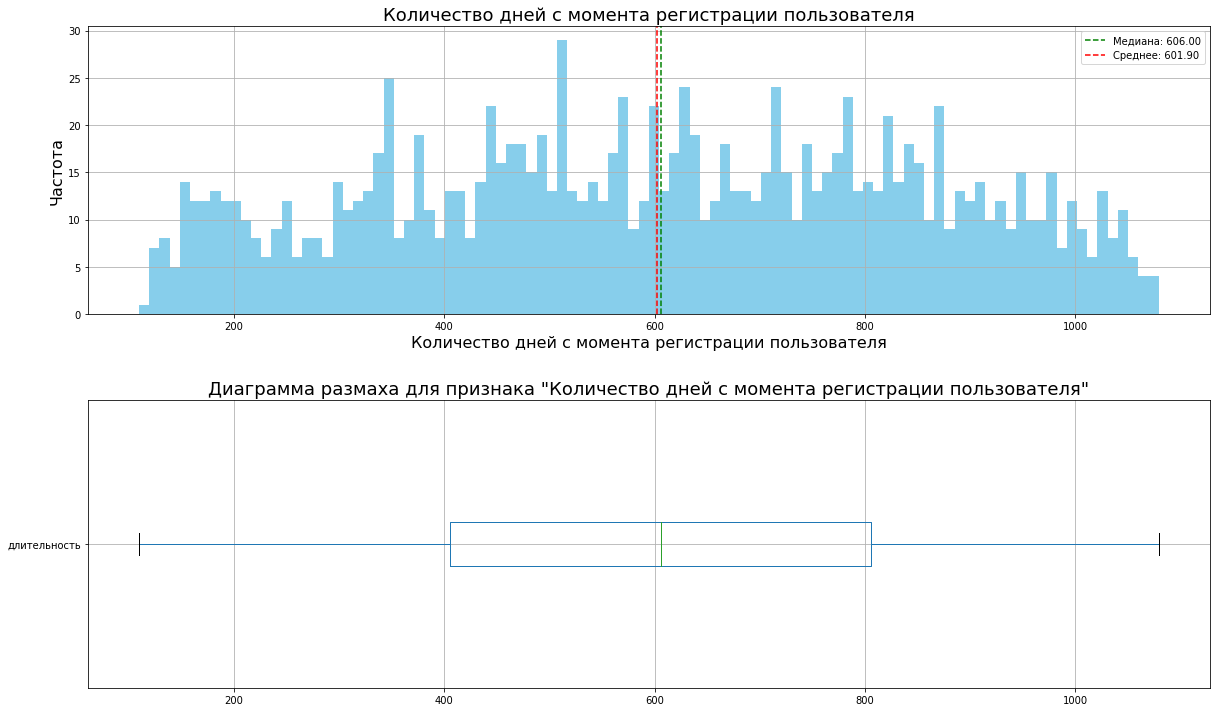

In [47]:
analyze_numerical_data(
    market_file, 'длительность', 'Количество дней с момента регистрации пользователя')

Значения признака "длительность" распределены в диапазоне от 110 до 1079 дней. Медианное значение - 606, среднее довольно близко к медианному - 601.9. Стандартное отклонение - 249.86 дней. Границы межквартильного размаха - от 405.5 до 806 дней. Выбросов нет.

In [48]:
(
    market_file
    .groupby('покупательская_активность')
    .agg(
        count=('id', 'count'),
        median_duration=('длительность', 'median'),
        median_market_6_mounts=('маркет_актив_6_мес', 'median'),
        median_market_current_mount=('маркет_актив_тек_мес', 'median')
    )
)

count  median_duration  median_market_6_mounts  \
покупательская_активность                                                   
Прежний уровень              802            590.0                     4.4   
Снизилась                    498            634.5                     3.9   

                           median_market_current_mount  
покупательская_активность                               
Прежний уровень                                      4  
Снизилась                                            4

У пользователей, чья покупательская активность снизилась, медианное количество дней с момента регистрации на сайте немного больше, чем у тех, чья покупательская активность прежняя - 634.5 и 590 соответственно. Медианное количество коммуникаций за 6 месяцев у этой группы меньше- 3.9 против 4.4. Медианное количество коммуникаций в текущем месяце одинаковое - 4.

Вторая группа признаков для изучения - __продуктовое поведение__:
- наиболее частая категория продукта в заказе    
- среднее число просматриваемых категорий продуктов за визит  
- число неоплаченных продуктов в корзине за последние три месяца    
- акционные покупки (стоит добавить в эту группу признаков)

Все признаки содержатся в датасете _market_file_.

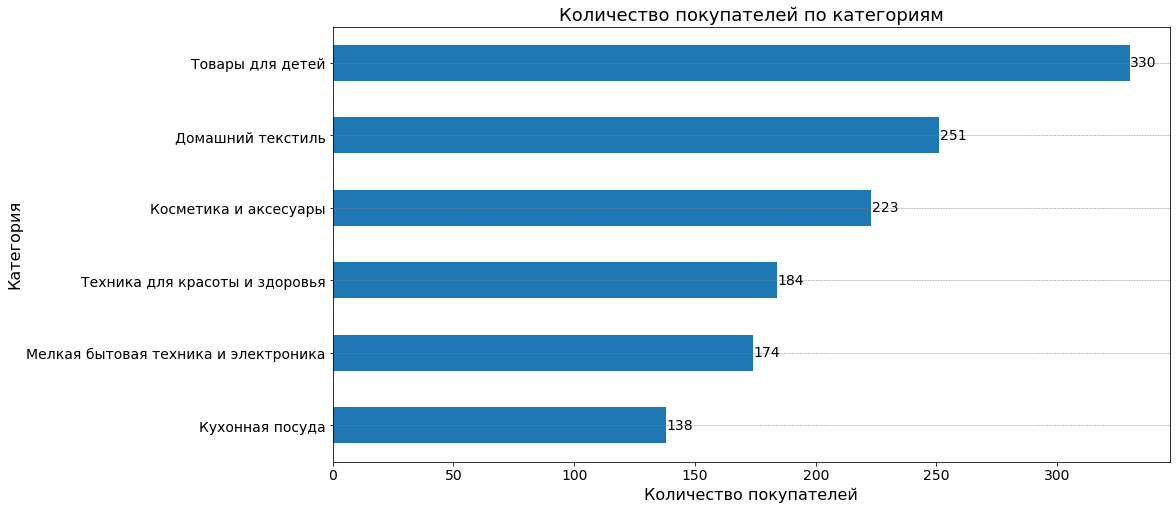

In [49]:
group_data = (
    market_file
    .groupby('популярная_категория')
    .agg({'id': 'count'})
    .sort_values('id', ascending=True)
)

fig, ax = plt.subplots(figsize=(15, 8))
ax = (
    group_data
    .plot(
        kind='barh',
        legend=False,
        grid=False,
        ax=ax,
        fontsize=14
    ))
for i in ax.patches:
    # Добавляем численные значения на столбцы
    ax.text(i.get_width()+.3, i.get_y()+.2, f"{int(i.get_width())}", fontsize=14, color='black')
    ax.axhline(y=i.get_y() + i.get_height()/2, color='gray', linestyle='--', linewidth=0.5)
    
ax.set_title('Количество покупателей по категориям', fontsize=TITLE_SIZE)
ax.set_xlabel('Количество покупателей', fontsize=LABEL_SIZE)
ax.set_ylabel('Категория', fontsize=LABEL_SIZE)
plt.show()

Средний просмотр категорий за визит


count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: средний_просмотр_категорий_за_визит, dtype: float64

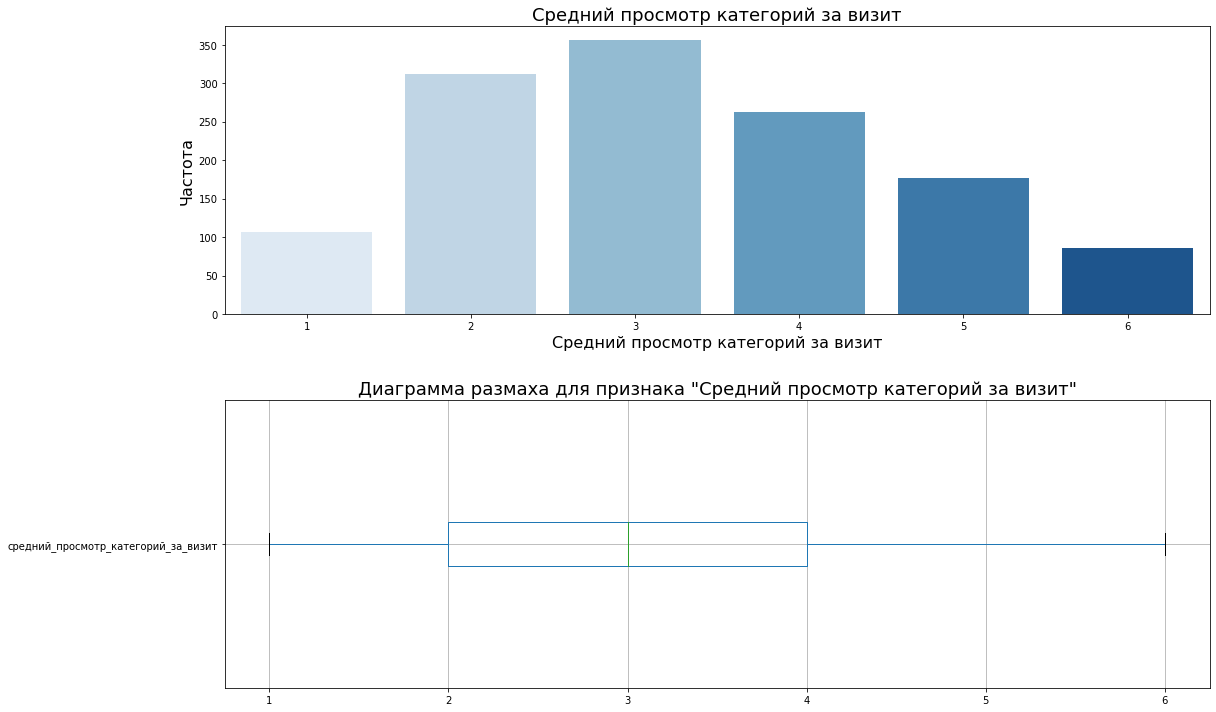

In [50]:
analyze_discrete_data(market_file, 'средний_просмотр_категорий_за_визит', 'Средний просмотр категорий за визит')

Количество неоплаченных продуктов за квартал


count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64

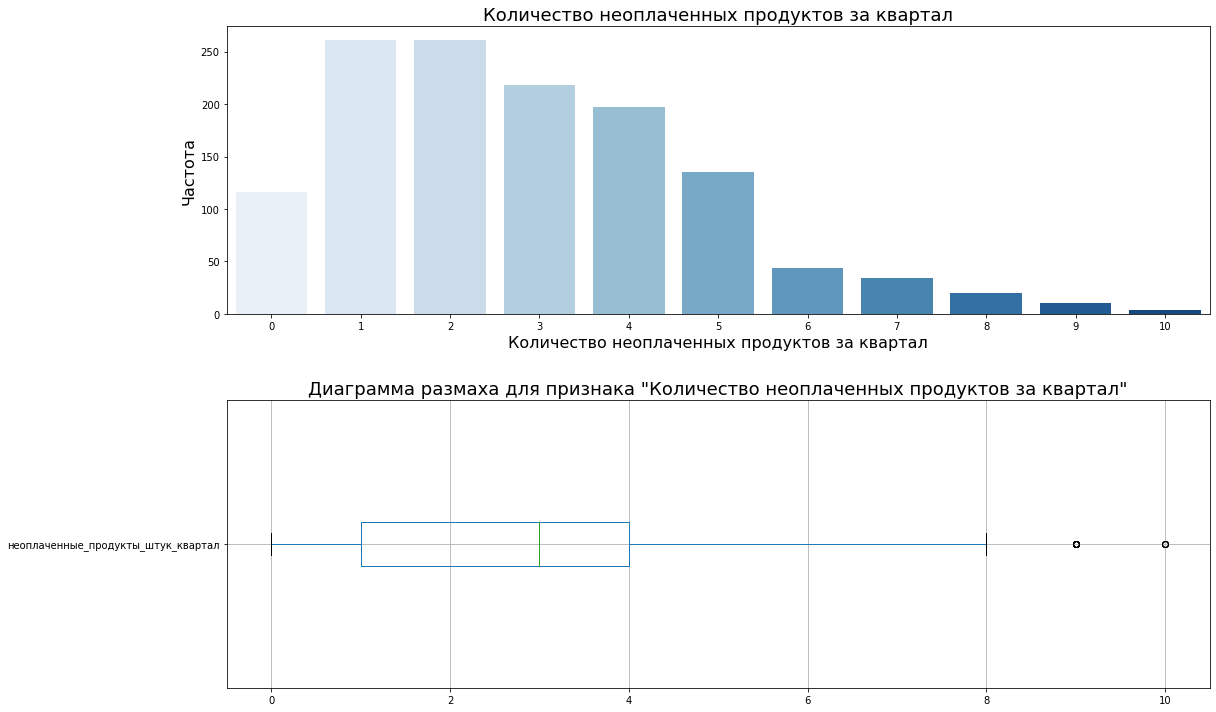

In [51]:
analyze_discrete_data(
    market_file, 'неоплаченные_продукты_штук_квартал', 'Количество неоплаченных продуктов за квартал')

Cреднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев


count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64

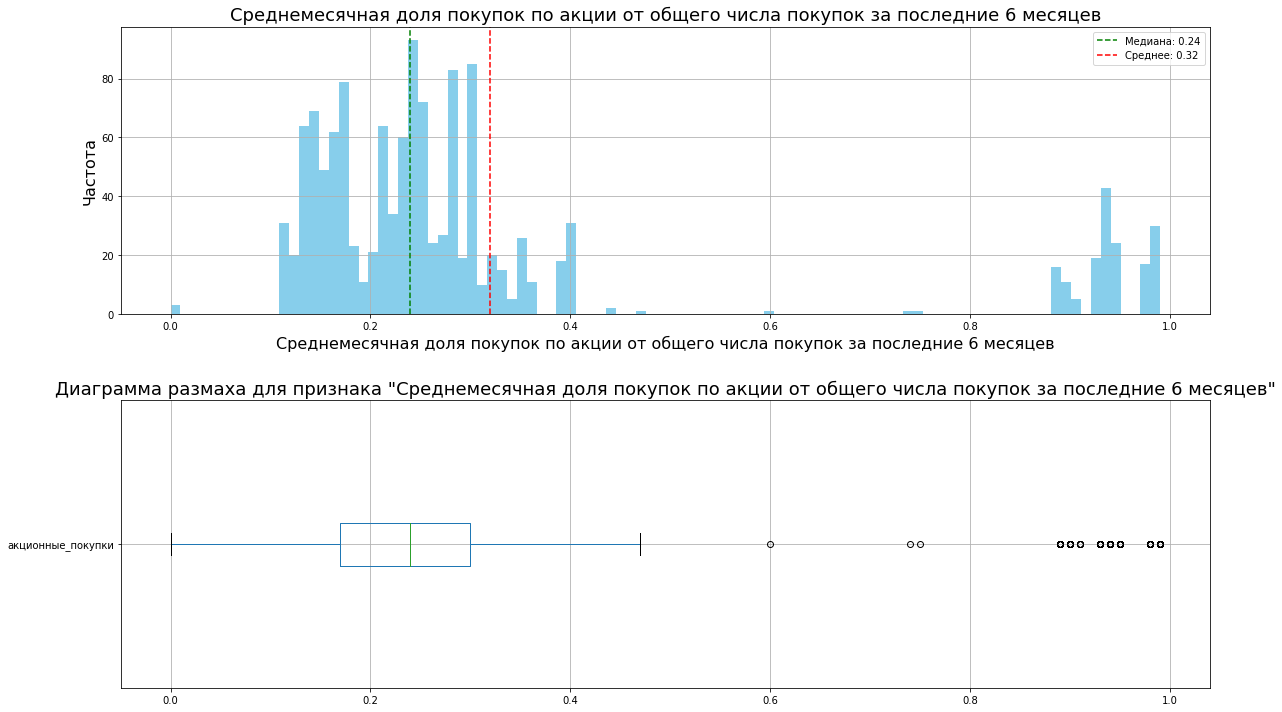

In [52]:
analyze_numerical_data(
    market_file, 'акционные_покупки',
    'Cреднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев')

In [53]:
(
    market_file
    .groupby('покупательская_активность')
    .agg(
        count=('id', 'count'),
        median_unpaid_products=('неоплаченные_продукты_штук_квартал', 'median'),
        median_avg_view =('средний_просмотр_категорий_за_визит', 'median'),
        median_promo_purchases=('акционные_покупки', 'median'),
       top_categories=('популярная_категория', lambda x: x.value_counts().nlargest(2).index.tolist())
    )
)

count  median_unpaid_products  median_avg_view  \
покупательская_активность                                                   
Прежний уровень              802                       2                4   
Снизилась                    498                       4                2   

                           median_promo_purchases  \
покупательская_активность                           
Прежний уровень                              0.21   
Снизилась                                    0.31   

                                                      top_categories  
покупательская_активность                                             
Прежний уровень                [Товары для детей, Домашний текстиль]  
Снизилась                  [Товары для детей, Косметика и аксесуары]

In [54]:
(
    market_file
    .groupby('тип_сервиса')
    .agg(
        count=('id', 'count'),
        median_unpaid_products=('неоплаченные_продукты_штук_квартал', 'median'),
        median_avg_view =('средний_просмотр_категорий_за_визит', 'median'),
        median_promo_purchases=('акционные_покупки', 'median'),
       top_categories=('популярная_категория', lambda x: x.value_counts().nlargest(2).index.tolist())
    )
)

count  median_unpaid_products  median_avg_view  \
тип_сервиса                                                   
премиум        376                       3                3   
стандарт       924                       3                3   

             median_promo_purchases                             top_categories  
тип_сервиса                                                                     
премиум                        0.24  [Товары для детей, Косметика и аксесуары]  
стандарт                       0.24      [Товары для детей, Домашний текстиль]

Наиболее частой категорией продукта в заказе является категория "Товары для детей" не зависимо от покупательской активности. Также в тройке самых популярных категории "Домашний текстиль" и "Косметика и аксесуары". Пользователи с уровнем сервиса "стандарт" больше интересуются категорией "Товары для детей" и "Косметика и аксесуары", а с уровнем "стандарт" - "Товары для детей" и "Домашний текстиль".

Среднее число просматриваемых категорий продуктов за визит находится в диапазоне от 1 до 6, межквартильные размах - от 2 до 4. Стандартное отклонение составляет 1.36. Среднее значение близко к медианному и равно 3.27, медиана равна 3. Выбросов нет.

Число неоплаченных продуктов в корзине за последние три месяца принимает значения от 0 до 10, межквартильный размах - от 1 до 4. Стандартное отклонение - 1.97. Среднее значение - 2.84, медиана - 3. Выбросов нет. Значения 9 и 10 являются редкими для датасета.

Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев лежит в диапазоне от 0 до 0.99, межквартильный размах от 0.17 до 0.3. Стандартное отклонение - 0.25. Среднее значение превышает медианное: 0.32 и 0.24 соответственно. На среднее значение влияют значения, превышающие 0.5, которые на диаграмме размаха определены как выбросы.

У покупателей, чья активность снизилась, медианное количество просмотров категорий за визит составляет 2, а число неоплаченных продуктов за последний квартал - 4, в то время как у покупателей с прежним уровнем активности - 4 категории и 2 продукта соответственно. Медианное значение доли покупок по акции у покупателей, чья активность снизилась, больше и составляет 0.31 против 0.21. Если рассматривать пользователей с разным типом сервиса, то медианные значения перечисленных выше параметров для них одинаковые. 

Третья группа признаков для изучения - __поведение на сайте__:
- число страниц за визит (за последние три месяца)
- сбои сайта 
- минут за визит 

Признаки содержатся в датасетах _market_file_ и _market_time_.

Cреднее количество страниц, просмотренных за один визит, за последние 3 месяца.


count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64

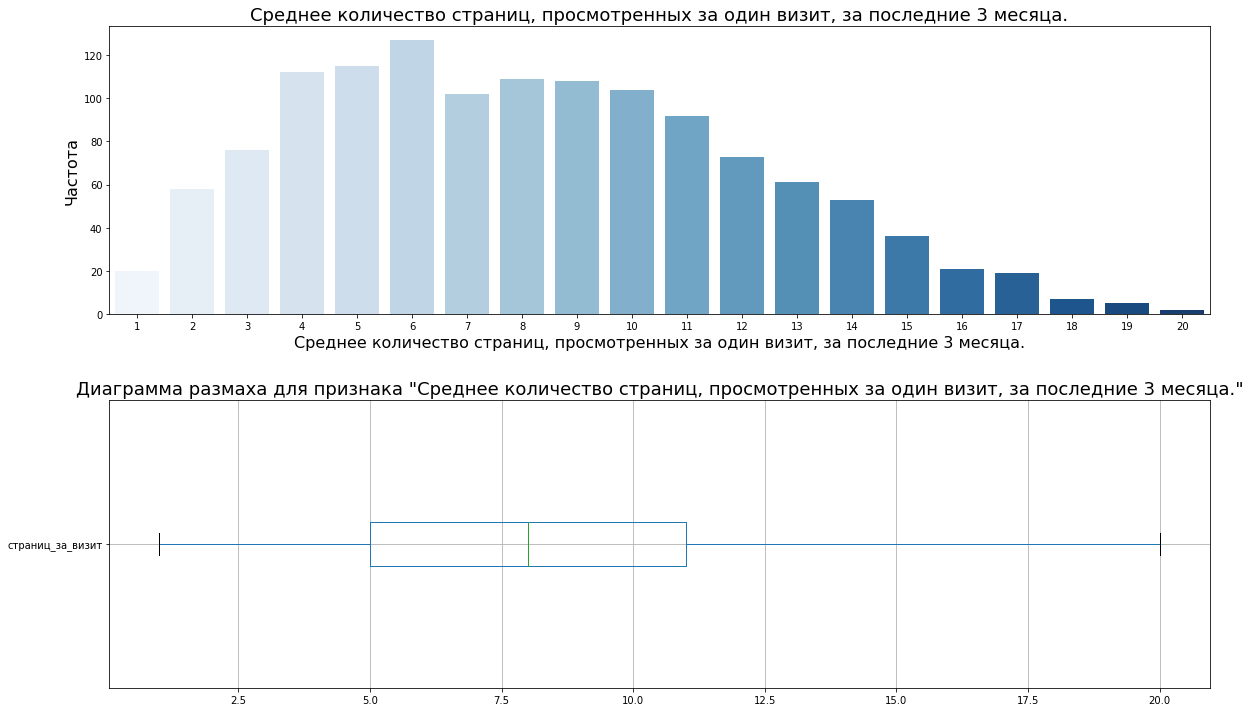

In [55]:
analyze_discrete_data(
    market_file, 'страниц_за_визит',
    'Cреднее количество страниц, просмотренных за один визит, за последние 3 месяца.')

Значения среднего количества страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца, лежат в диапазоне от 1 до 20, межквартильный размах - от 5 до 11. Мода - 6, среднее значение - 8.18, медиана - 8. Стандартное отклонение - 3.98. Выбросов нет. 

Число сбоев, которые коснулись покупателя во время посещения сайта


count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64

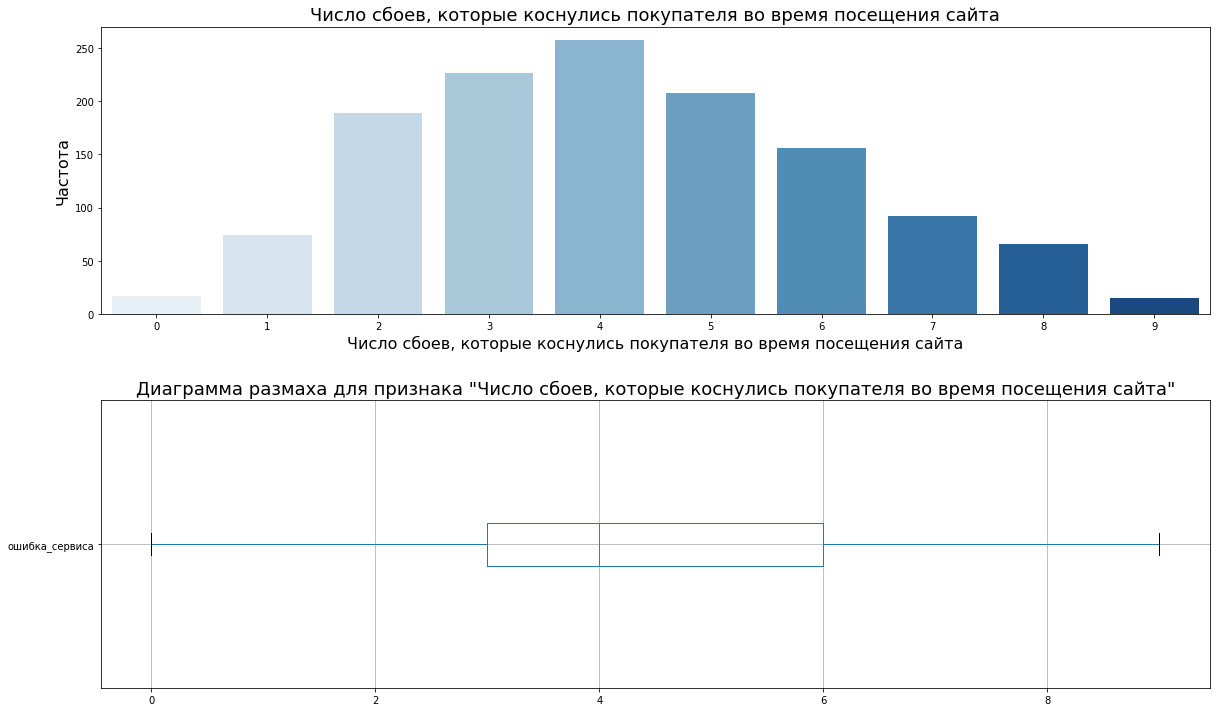

In [56]:
analyze_discrete_data(
    market_file, 'ошибка_сервиса',
    'Число сбоев, которые коснулись покупателя во время посещения сайта')

Значения число сбоев, которые коснулись покупателя во время посещения сайта, лежат в диапазоне от 0 до 9, межквартильный размах - от 3 до 6. Мода равна медиане - 4, среднее значение - 4.19. Стандартное отклонение - 1.96. Выбросов нет.

In [57]:
market_file.groupby('покупательская_активность').agg(
    count=('id', 'count'),
    median_pages=('страниц_за_визит', 'median'),
    median_errors=('ошибка_сервиса', 'median')
)

count  median_pages  median_errors
покупательская_активность                                    
Прежний уровень              802            10              4
Снизилась                    498             5              4

In [58]:
market_file.groupby('тип_сервиса').agg(
    count=('id', 'count'),
    median_pages=('страниц_за_визит', 'median'),
    median_errors=('ошибка_сервиса', 'median')
)

count  median_pages  median_errors
тип_сервиса                                    
премиум        376             8              4
стандарт       924             8              4

Медианные значения среднего числа страниц за визит и сбоев, которые коснулись покупателя во время посещения сайта, одинаковы для каждой группы по типу сервиса. Стоит отметить, что медианное значение среднего числа страниц за визит намного меньше у пользователей, чья покупательская активность снизилась, и составляет 5 против 10 у пользователей, чья активность на прежнем уровне.

In [59]:
market_time['период'].value_counts()

предыдущий_месяц    1300
текущий_месяц       1300
Name: период, dtype: int64

Время, проведённое на сайте, в минутах


count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

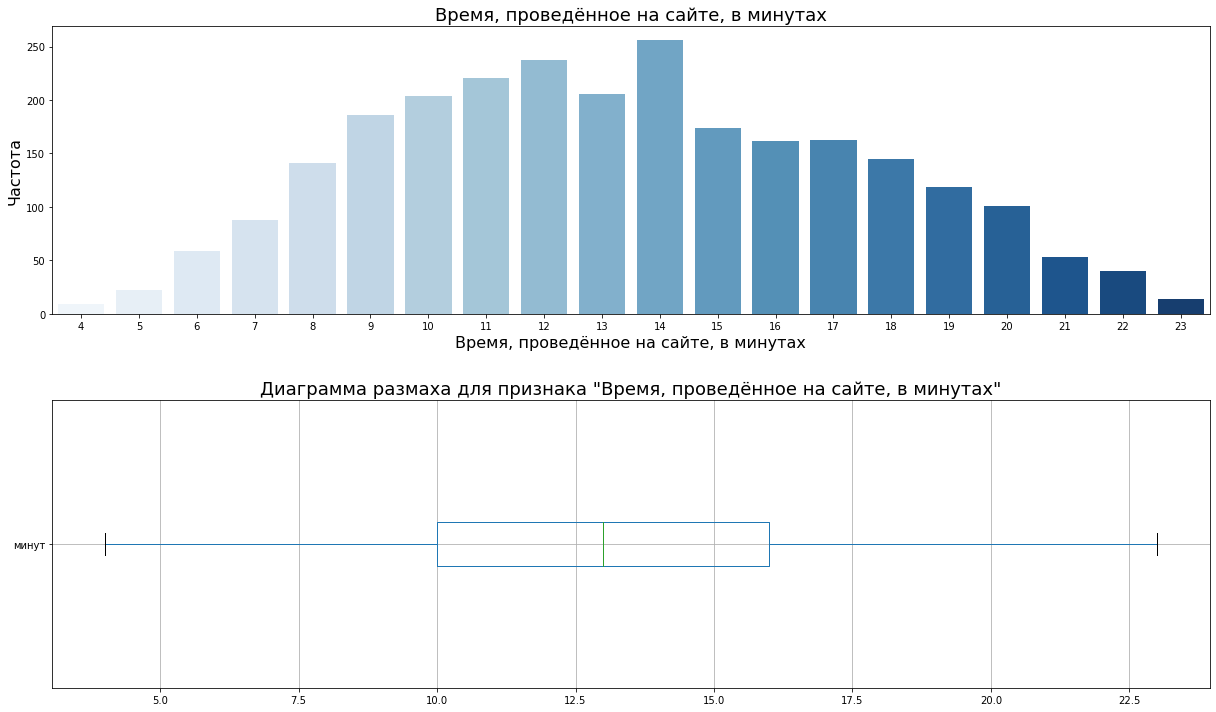

In [60]:
analyze_discrete_data(
    market_time, 'минут', 'Время, проведённое на сайте, в минутах')

In [61]:
market_time.groupby('период').agg(
    count=('id', 'count'),
    median_time=('минут', 'median')
)

count  median_time
период                              
предыдущий_месяц   1300           13
текущий_месяц      1300           13

Значения времени, проведённого на сайте за период, находятся в диапазоне от 4 до 23 минут, межквартильный размах - от 10 до 16 минут, стандартное отклонение - 4.08 минут. Среднее значение близко к медианному - 13.34 и 13 минут соответственно. Выбросов нет. За текущий и предыдущий месяц медианные значения времени, проведённого на сайте, равны и составляют 13 минут.

Четвертая группа признаков для изучения - __финансовое поведение__:
- выручка, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом
- среднемесячная прибыль с покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

Признаки содержатся в датасетах _market_money_ и _money_.

Среднемесячная прибыль с покупателя за последние 3 месяца


count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

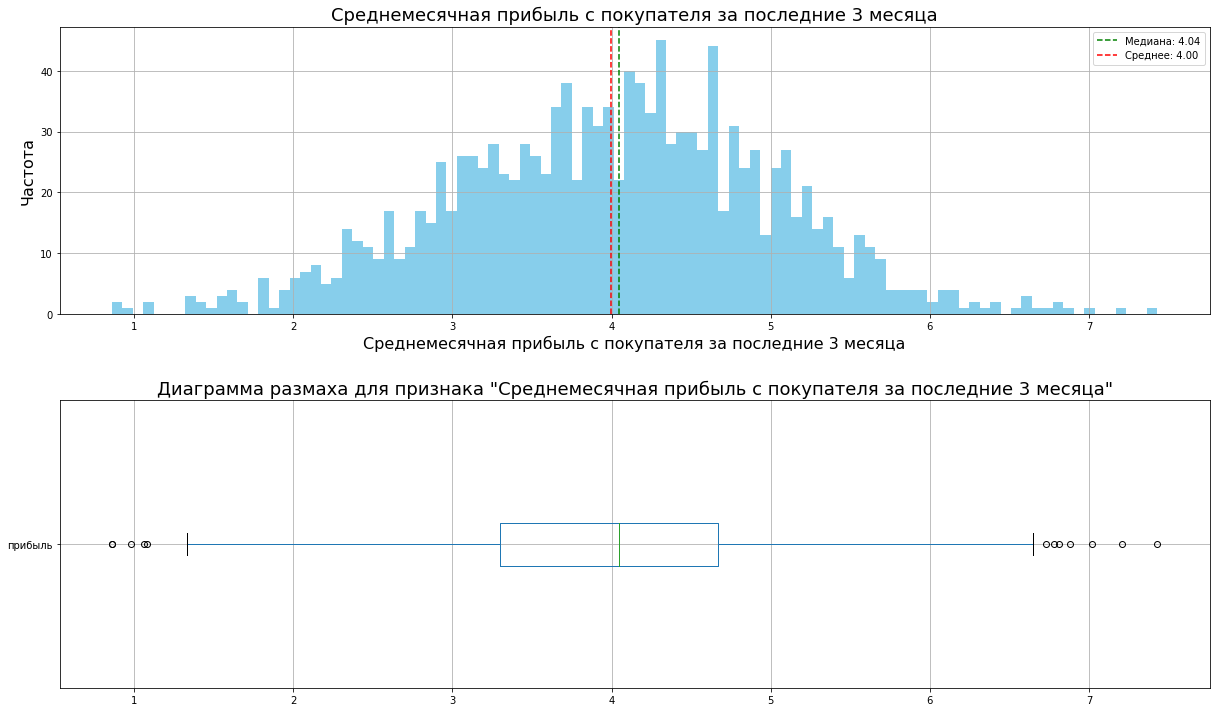

In [62]:
analyze_numerical_data(
    money, 'прибыль', 'Среднемесячная прибыль с покупателя за последние 3 месяца')

Значения среднемесячной прибыли с покупателя за последние 3 месяца находятся в диапазоне от 0.86 до 7.43, межквартильный размах от 3.3 до 4.67, стандартное отклонение 1.01. Среднее значение немного меньше медианного - 4 и 4.05 соответственно. Присутсвуют нетипичные наблюдения.

Выручка за период


count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64

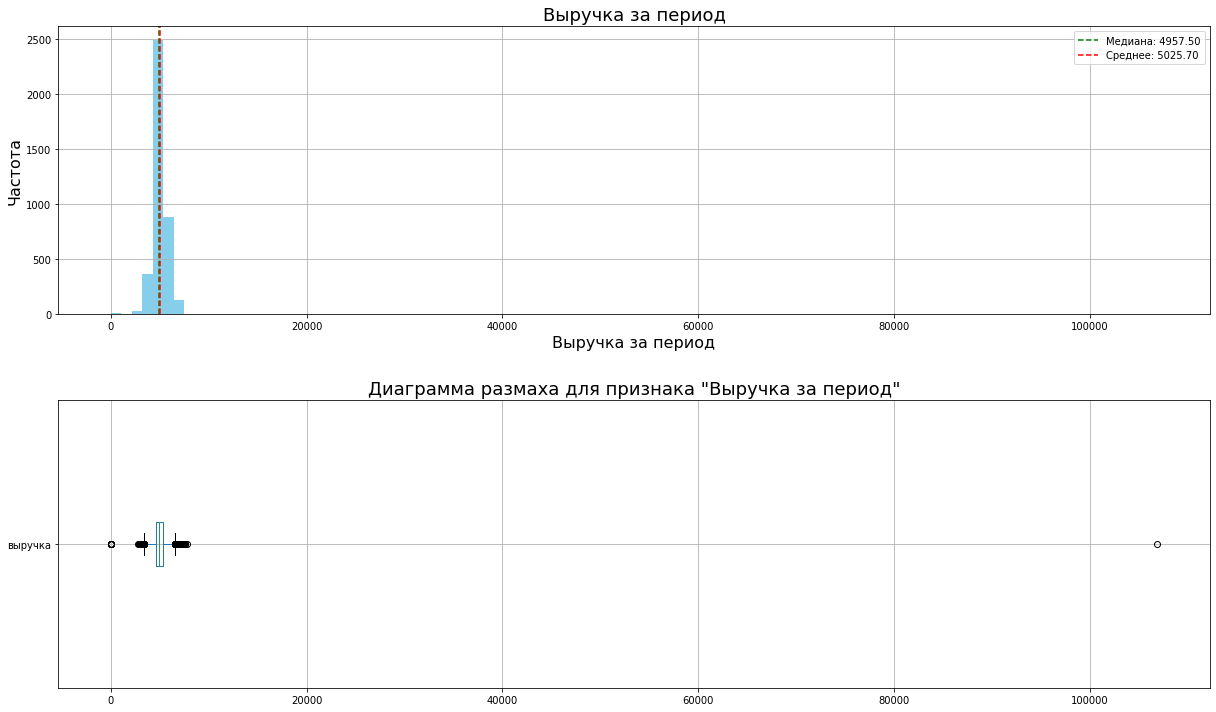

In [63]:
analyze_numerical_data(
    market_money, 'выручка', 'Выручка за период')

Значение более 100 тыс. явно является аномалией для выборки (возможно, это ошибка в данных, либо аномальная выручка, например, полученная в случае огромной совместной закупки, что не отражает общие тенденции). Удалим его и повторим анализ для данного признака. 

In [64]:
# определим id покупателя с выручкой больше 10000
id_to_delete = market_money[market_money['выручка'] > 10000]['id'].to_list()
id_to_delete

[215380]

In [65]:
# исключаем строки с id покупателя с выручкой больше 10000
market_money = market_money[~market_money['id'].isin(id_to_delete)]

Выручка за период


count    3897.000000
mean     4999.287760
std       706.970089
min         0.000000
25%      4590.000000
50%      4956.000000
75%      5363.000000
max      7799.400000
Name: выручка, dtype: float64

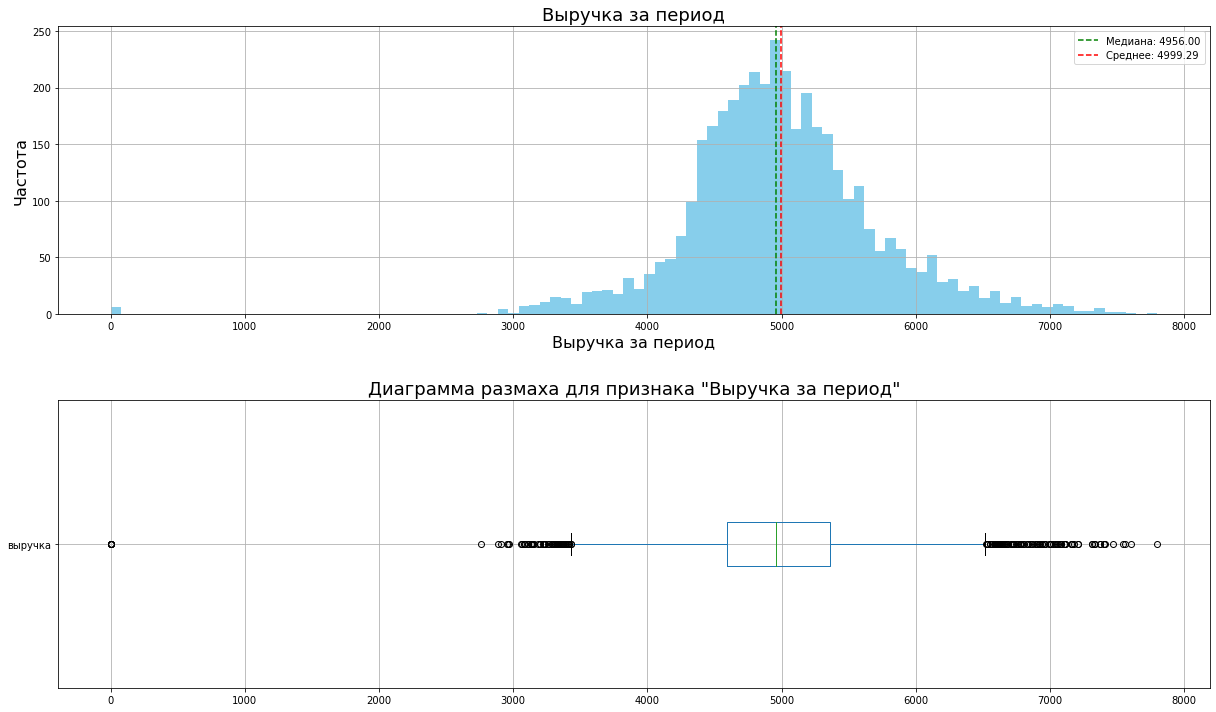

In [66]:
analyze_numerical_data(
    market_money, 'выручка', 'Выручка за период')

Значения выручки за период, которую получает магазин с покупателя, находятся в диапазоне от 0 до 7799.4, межквартильный размах от 4590 до 5363, стандартное отклонение 706.97. Среднее значение превышает медианное - 4999.29 и 4956 соответственно. Присутсвуют нетипичные наблюдения.

In [67]:
market_money['период'].value_counts()

предыдущий_месяц       1299
препредыдущий_месяц    1299
текущий_месяц          1299
Name: период, dtype: int64

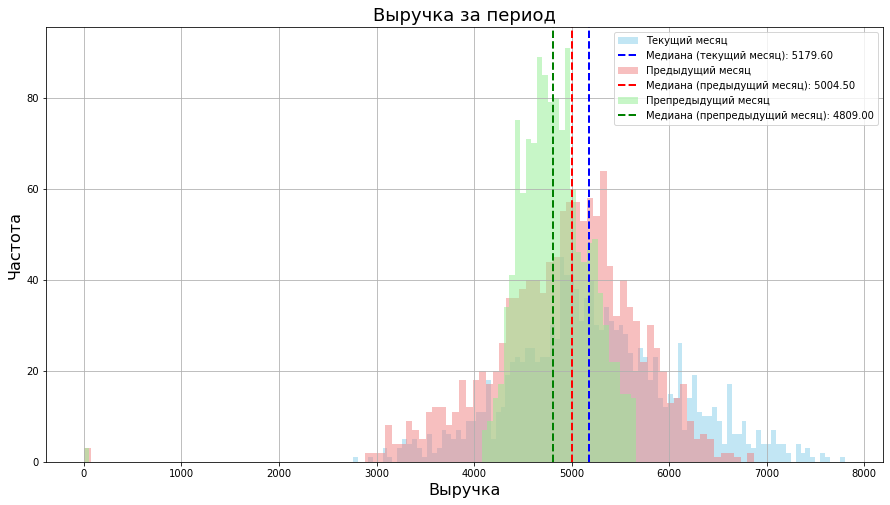

In [68]:
plt.figure(figsize=(15, 8))

# Построение гистограммы за текущий месяц
plt.hist(market_money[market_money['период'] == 'текущий_месяц']['выручка'], bins=100, color='skyblue', alpha=0.5, label='Текущий месяц')
median_1 = market_money[market_money['период'] == 'текущий_месяц']['выручка'].median()
plt.axvline(median_1, color='blue', linestyle='dashed', linewidth=2, label=f'Медиана (текущий месяц): {median_1:.2f}')

# Построение гистограммы за предыдущий месяц
plt.hist(market_money[market_money['период'] == 'предыдущий_месяц']['выручка'], bins=100, color='lightcoral', alpha=0.5, label='Предыдущий месяц')
median_2 = market_money[market_money['период'] == 'предыдущий_месяц']['выручка'].median()
plt.axvline(median_2, color='red', linestyle='dashed', linewidth=2, label=f'Медиана (предыдущий месяц): {median_2:.2f}')

# Построение гистограммы за препредыдущий месяц
plt.hist(market_money[market_money['период'] == 'препредыдущий_месяц']['выручка'], bins=100, color='lightgreen', alpha=0.5, label='Препредыдущий месяц')
median_3 = market_money[market_money['период'] == 'препредыдущий_месяц']['выручка'].median()
plt.axvline(median_3, color='green', linestyle='dashed', linewidth=2, label=f'Медиана (препредыдущий месяц): {median_3:.2f}')

plt.title('Выручка за период', fontsize=TITLE_SIZE)
plt.xlabel('Выручка', fontsize=LABEL_SIZE)
plt.ylabel('Частота', fontsize=LABEL_SIZE)
plt.legend()
plt.grid(True) 
plt.legend()
plt.show()

Можно заметить, что характер распределения выручки с каждым месяцем изменяется. Разброс становится более широким с каждым месяцем, увеличивается вариативность данных. Вместе с тем, медианное значение выручки растет. 

Для дальнейшей работы отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Эти данные находятся в датасете _market_money_. Нам нужно отобрать клиентов, которые делали покупку каждый месяц.

In [69]:
# количество уникальных id
market_file['id'].nunique()

1300

In [70]:
list_of_all_ids = market_file['id'].tolist()
list_of_id_with_zero_purchases = market_money[market_money['выручка'] == 0]['id'].tolist()

list_of_id_final = [
    item for item in list_of_all_ids if item not in list_of_id_with_zero_purchases]

# не забываем удалить id с аномальной выручкой
try:
    list_of_id_final.remove(id_to_delete[0])  
except ValueError:
    print(f"Пользователь с id= {id_to_delete} не найден в списке")
    
len(list_of_id_final)

1296

В переменной list_of_id_final хранится список id покупателей, которые совершали покупки в каждый из последних трех месяцев. id пользователя с аномальной выручкой не входит в этот список. Таких покупателей 1296 из 1300.

__Вывод__:
1. Провели исследовательский анализ данных.
- __Целевой признак__ - класс покупательской активности. В предоставленном датасете наблюдаем, что активность 38.3% покупателей снизилась.
- Признаки, характеризующие __коммуникацию с клиентом__:
    - В предоставленных данных преобладают клиенты с уровнем обслуживания "стандарт" (71.1%). 74% покупателей дали согласие на рассылку дополнительных предложений. Вместе с тем, покупатели с уровнем обслуживания 'премиум' чаще соглашались на рассылку: 86.97% против 68.72%. Среди пользователей с уровнем обслуживания "стандарт" наблюдается снижение покупательской активности у 35.5% покупателей, среди пользователей с уровнем обслуживания "премиум" - 45.21%. Снижение уровня покупательской активности среди тех, кто получает уведомления о новых предложениях, и тех, кто от них отказался, практически одинаковый - 38.57% и 37.57%.
    - Значения признака "маркет_актив\_6\_мес" распределены в диапазоне от 0.9 до 6.6. Медианное значение - 4.2, среднее довольно близко к медианному - 4.25. Стандартное отклонение - 1.01. Границы межквартильного размаха - от 3.7 до 4.9. Часть наблюдений опредлена как выбросы (меньше 2 маркетинговых коммуникаций за 6 месяцев). Вместе с тем, эти значения не являются аномальными, оставим их. К тому же, если рассмотреть их вместе с целевым признаком, почти у всех покупателей наблюдалось снижение покупательской активности.
    - Количество маркетинговых коммуникаций в текущем месяце лежит в диапазоне от 3 до 5, более половины значений - 4 взаимодействия (межквартильный размах - от 4 до 4), мода и медиана равны 4, среднее взначение - 4.01, стандартное отклонение - 0.7. Учитывая небольшой разброс, можно говорить о стабильности коммуникаций в текущем месяце. 
    - Значения признака "длительность" распределены в диапазоне от 110 до 1079 дней. Медианное значение - 606, среднее довольно близко к медианному - 601.9. Стандартное отклонение - 249.86 дней. Границы межквартильного размаха - от 405.5 до 806 дней. Выбросов нет.
    - У пользователей, чья покупательская активность снизилась, медианное количество дней с момента регистрации на сайте немного больше, чем у тех, чья покупательская активность прежняя - 634.5 и 590 соответственно. Медианное количество коммуникаций за 6 месяцев у этой группы меньше- 3.9 против 4.4. Медианное количество коммуникаций в текущем месяце одинаковое - 4.
    
- Признаки, характеризующие __продуктовое поведение__:
    - Наиболее частой категорией продукта в заказе является категория "Товары для детей" не зависимо от покупательской активности. Также в тройке самых популярных категории "Домашний текстиль" и "Косметика и аксесуары". Пользователи с уровнем сервиса "стандарт" больше интересуются категорией "Товары для детей" и "Косметика и аксесуары", а с уровнем "стандарт" - "Товары для детей" и "Домашний текстиль".
    - Среднее число просматриваемых категорий продуктов за визит находится в диапазоне от 1 до 6, межквартильные размах - от 2 до 4. Стандартное отклонение составляет 1.36. Среднее значение близко к медианному и равно 3.27, медиана равна 3. Выбросов нет.
    - Число неоплаченных продуктов в корзине за последние три месяца принимает значения от 0 до 10, межквартильный размах - от 1 до 4. Стандартное отклонение - 1.97. Среднее значение - 2.84, медиана - 3. Выбросов нет. Значения 9 и 10 являются редкими для датасета.
    - Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев лежит в диапазоне от 0 до 0.99, межквартильный размах от 0.17 до 0.3. Стандартное отклонение - 0.25. Среднее значение превышает медианное: 0.32 и 0.24 соответственно. На среднее значение влияют значения, превышающие 0.5, которые на диаграмме размаха определены как выбросы.
    - У покупателей, чья активность снизилась, медианное количество просмотров категорий за визит составляет 2, а число неоплаченных продуктов за последний квартал - 4, в то время как у покупателей с прежним уровнем активности - 4 категории и 2 продукта соответственно. Медианное значение доли покупок по акции у покупателей, чья активность снизилась, больше и составляет 0.31 против 0.21. Если рассматривать пользователей с разным типом сервиса, то медианные значения перечисленных выше параметров для них одинаковые.

- Признаки, характеризующие __поведение на сайте__:
    - Значения среднего количества страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца, лежат в диапазоне от 1 до 20, межквартильный размах - от 5 до 11. Мода - 6, среднее значение - 8.18, медиана - 8. Стандартное отклонение - 3.98. Выбросов нет.  
    - Значения число сбоев, которые коснулись покупателя во время посещения сайта, лежат в диапазоне от 0 до 9, межквартильный размах - от 3 до 6. Мода равна медиане - 4, среднее значение - 4.19. Стандартное отклонение - 1.96. Выбросов нет. Медианные значения среднего числа страниц за визит и сбоев, которые коснулись покупателя во время посещения сайта, одинаковы для каждой группы по типу сервиса. Медианное значение среднего числа страниц за визит намного меньше у пользователей, чья покупательская активность снизилась, и составляет 5 против 10 у пользователей, чья активность на прежнем уровне.
    - Значения времени, проведённого на сайте за период, находятся в диапазоне от 4 до 23 минут, межквартильный размах - от 10 до 16 минут, стандартное отклонение - 4.08 минут. Среднее значение близко к медианному - 13.34 и 13 минут соответственно. Выбросов нет. За текущий и предыдущий месяц медианные значения времени, проведённого на сайте, равны и составляют 13 минут.    
    
- Признаки, характеризующие __финансовое поведение__:
    - Значения среднемесячной прибыли с покупателя за последние 3 месяца находятся в диапазоне от 0.86 до 7.43, межквартильный размах от 3.3 до 4.67, стандартное отклонение 1.01. Среднее значение немного меньше медианного - 4 и 4.05 соответственно. Присутсвуют нетипичные наблюдения.
    - Удалили данные о пользователес аномально большим значение выручки (более 100 тыс.) из датасета _market_money_. 
    - Значения выручки за период, которую получает магазин с покупателя, находятся в диапазоне от 0 до 7799.4, межквартильный размах от 4590 до 5363, стандартное отклонение 706.97. Среднее значение превышает медианное - 4999.29 и 4956 соответственно. Присутсвуют нетипичные наблюдения. Характер распределения выручки с каждым месяцем изменяется. Разброс становится более широким, увеличивается вариативность данных. Вместе с тем, медианное значение выручки растет.
    
2. Мы создали список id покупателей, которые совершали покупки в каждый из последних трех месяцев. id пользователя с аномальной выручкой не входит в этот список. Таких покупателей 1296 из 1300.

## Объединение таблиц

Объединим таблицы market_file, market_money, market_time. Будем проводить объединение по столбцу id,  используем merge.
Предварительно преобразуем датасеты market_money, market_time так, чтобы значения за каждый период содержались в отдельных колонках. Заодно сразу оставим только тех пользователей, которых отобрали на предыдущем шаге.

In [71]:
# pivot_table подходит для нашего случая с mean, т.к. у нас только одно значение для каждой пары id и периода
pivot_market_money = pd.pivot_table(
    market_money,
    index='id',
    columns='период',
    values='выручка'
)
pivot_market_money.columns = [f'выручка_{col}' for col in pivot_market_money.columns]
pivot_market_money = pivot_market_money.reset_index()

# проверим размерность, пропуски и названия столбцов
pivot_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           1299 non-null   int64  
 1   выручка_предыдущий_месяц     1299 non-null   float64
 2   выручка_препредыдущий_месяц  1299 non-null   float64
 3   выручка_текущий_месяц        1299 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 40.7 KB


In [72]:
pivot_market_time = pd.pivot_table(
    market_time,
    index='id',
    columns='период',
    values='минут'
)
pivot_market_time.columns = [f'время_{col}' for col in pivot_market_time.columns]
pivot_market_time = pivot_market_time.reset_index()

# проверим размерность, пропуски и названия столбцов
pivot_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   id                      1300 non-null   int64
 1   время_предыдущий_месяц  1300 non-null   int64
 2   время_текущий_месяц     1300 non-null   int64
dtypes: int64(3)
memory usage: 30.6 KB


In [73]:
full_data = (
    market_file[market_file['id'].isin(list_of_id_final)]
    .merge(pivot_market_money, on='id')
    .merge(pivot_market_time, on='id')
)

# проверим размерность, пропуски и названия столбцов
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

In [74]:
full_data.head()

id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215349                 Снизилась     премиум                 да   
1  215350                 Снизилась    стандарт                нет   
2  215351                 Снизилась    стандарт                 да   
3  215352                 Снизилась    стандарт                нет   
4  215353                 Снизилась    стандарт                 да   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 4.4                     4           819               0.75   
1                 4.9                     3           539               0.14   
2                 3.2                     5           896               0.99   
3                 5.1                     3          1064               0.94   
4                 3.3                     4           762               0.26   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    4   
1    Домашний текстиль                                    5   
2     Товары для детей                                    5   
3     Товары для детей                                    3   
4    Домашний текстиль                                    4   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
0                                   4               2                 5   
1                                   2               1                 5   
2                                   0               6                 4   
3                                   2               3                 2   
4                                   1               1                 4   

   выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
0                    5216.0                       4472.0   
1                    5457.5                       4826.0   
2                    6158.0                       4793.0   
3                    5807.5                       4594.0   
4                    4738.5                       5124.0   

   выручка_текущий_месяц  время_предыдущий_месяц  время_текущий_месяц  
0                 4971.6                      12                   10  
1                 5058.4                       8                   13  
2                 6610.4                      11                   13  
3                 5872.5                       8                   11  
4                 5388.5                      10                   10

In [75]:
# проверим, что все id вошли в итоговую выборку
full_data['id'].isin(list_of_id_final).sum()

1296

__Вывод__:
- Объединили таблицы market_file, market_money, market_time. Значения времени и выручки за каждый период содержатся в отдельных колонках. Датасет содержит 1296 записей о покупателях, которые совершали покупки в каждый из последних трех месяцев.

## Корреляционный анализ

Рассчитаем коэффициенты корреляции между признаками для full_data. Будем использовать phik, поэтому категориальные признаки можно оставить.

In [76]:
# создадим списки с количественными и категориальными признаками
cat_col_names = full_data.drop(
    columns=['id', 'покупательская_активность']).select_dtypes(exclude='number').columns.tolist()
num_col_names = full_data.drop(
    columns=['id', 'покупательская_активность']).select_dtypes(include='number').columns.tolist()

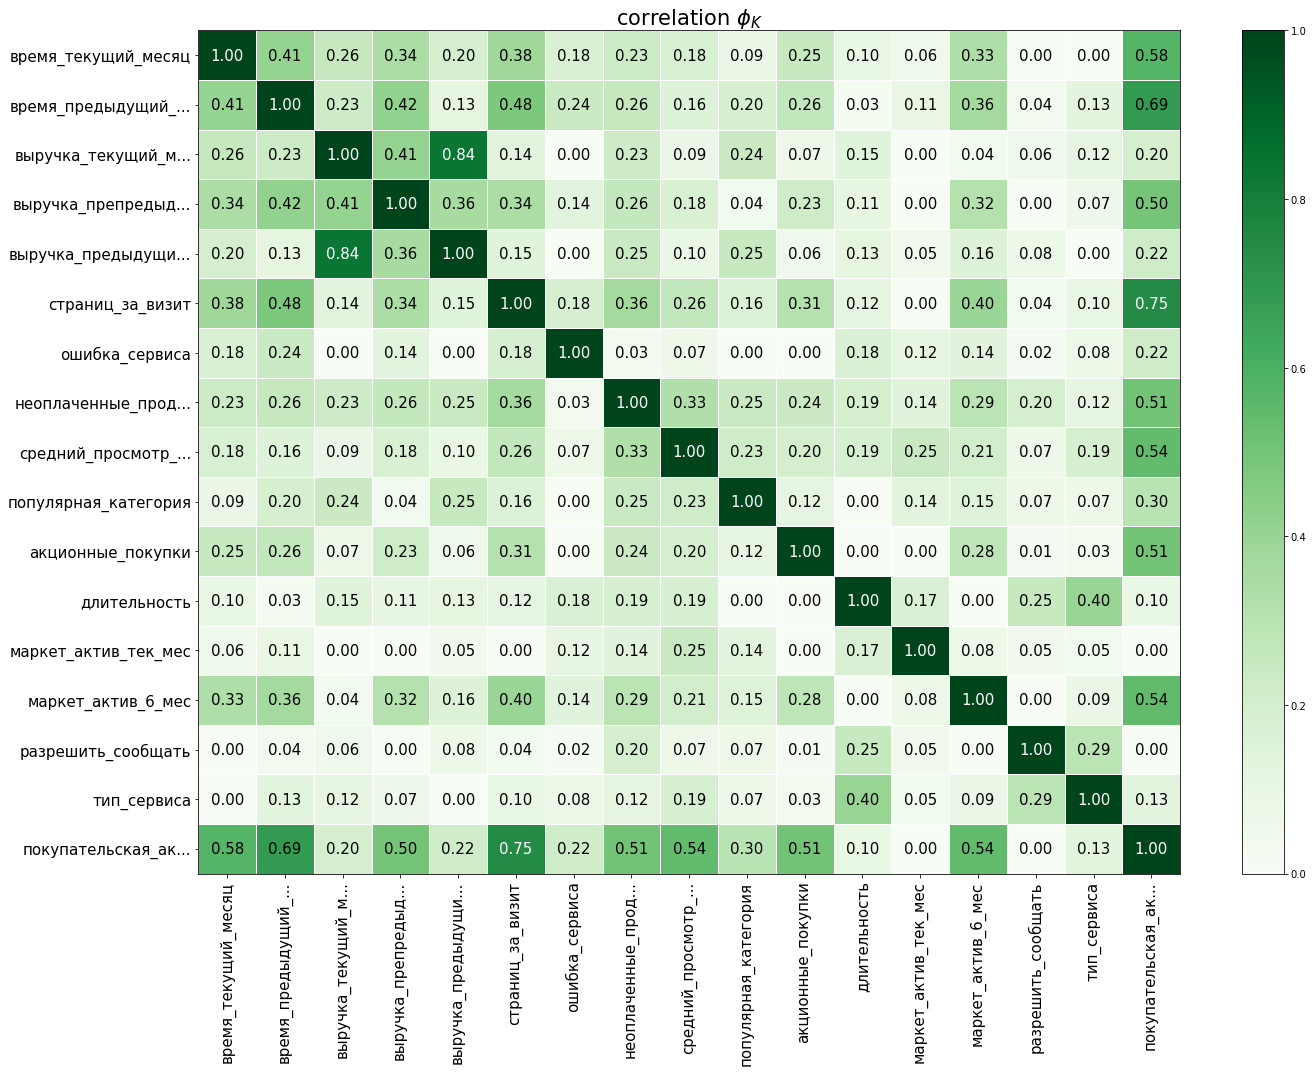

In [77]:
phik_overview = phik_matrix(full_data.drop(columns=['id']), interval_cols=num_col_names) 

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Целевой признак - это "покупательская_активность":
- наблюдается __высокая взаимосвязь__ с признаком 'страниц_за_визит',
- __заметная взаимосвязь__ с признаками 'маркет_актив\_6\_мес' и 'маркет_актив_тек_мес', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'время_предыдущий_месяц', 'время_текущий_месяц',
- __умеренная взаимосвязь__ с признаком 'популярная_категория',
- __слабая взаимосвязь__ с признаками 'тип_сервиса', 'длительность', 'ошибка_сервиса', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц', 'выручка
- __взаимосвязь не выявлена__ с признаками 'разрешить_сообщать', 'маркет_актив_тек_мес',
- 'id' является просто идентификатором, на целевой признак влияния оказывать не может.

Мультиколлинеарности (коффициента больше 0.9) между входными признаками нет, однако стоит отметить высокую взаимосвязь между признаками 'выручка_текущий_месяц' и 'выручка_предыдущий_месяц' (0.84).

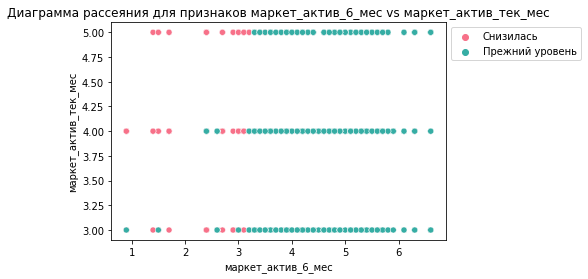

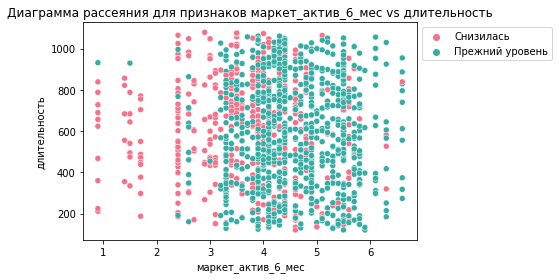

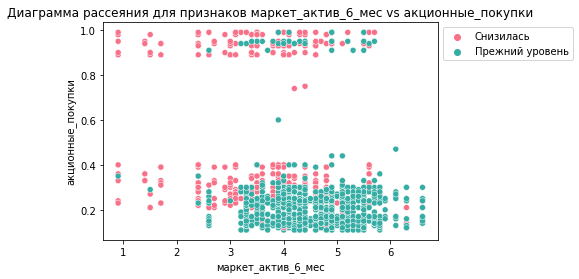

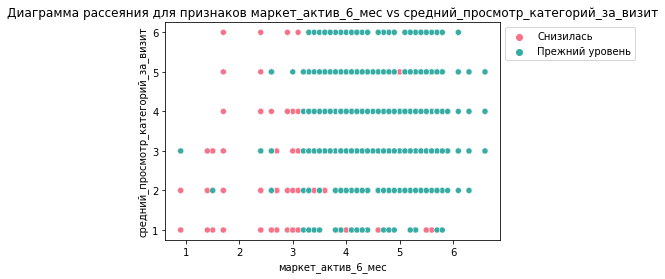

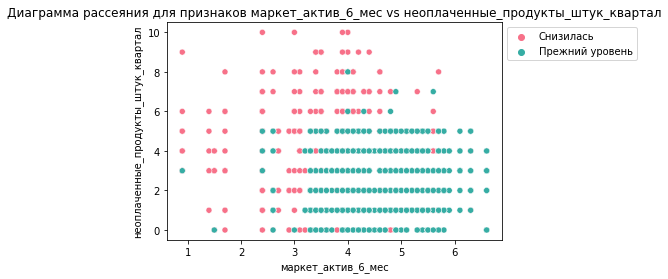

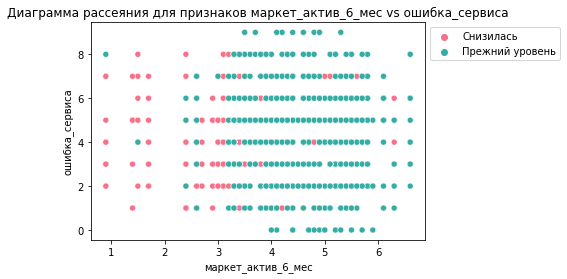

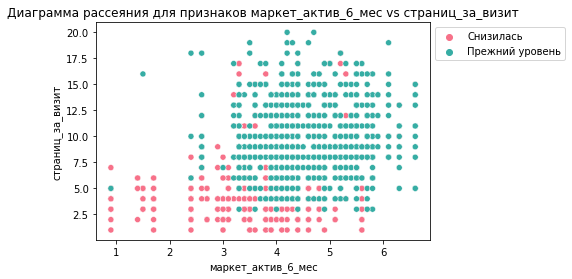

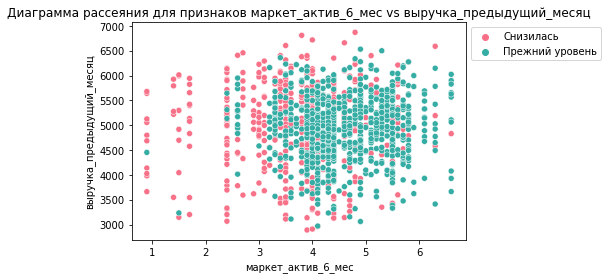

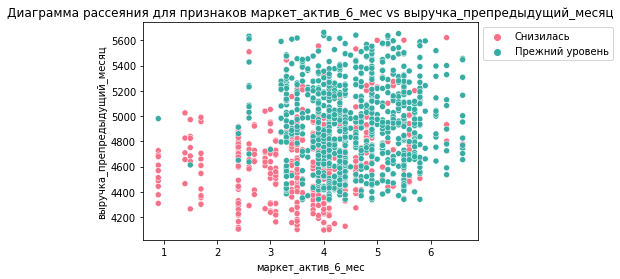

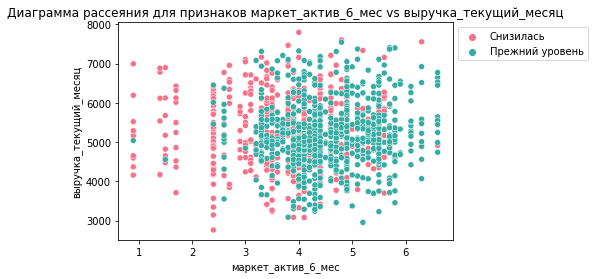

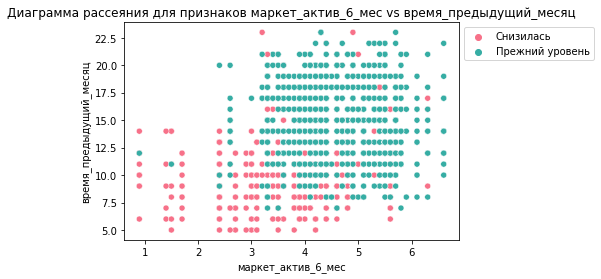

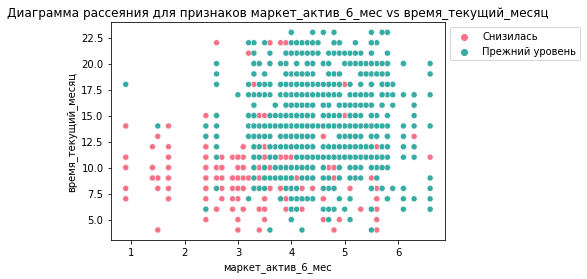

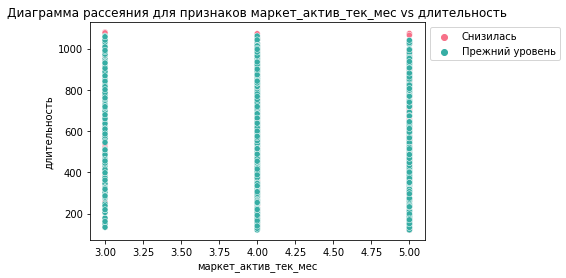

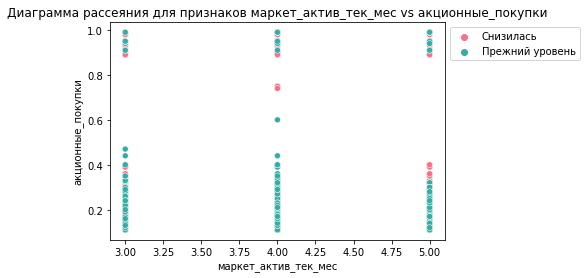

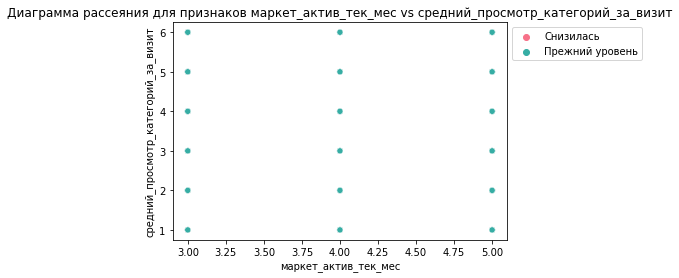

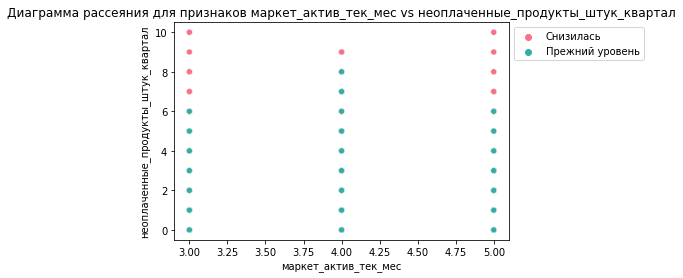

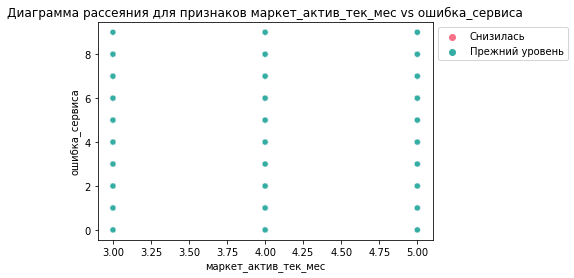

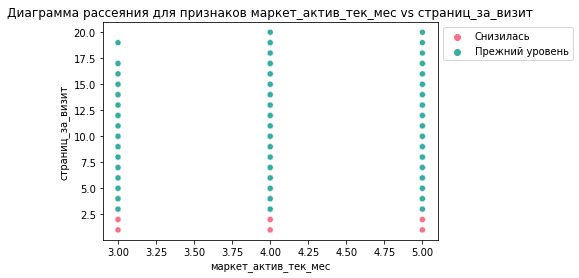

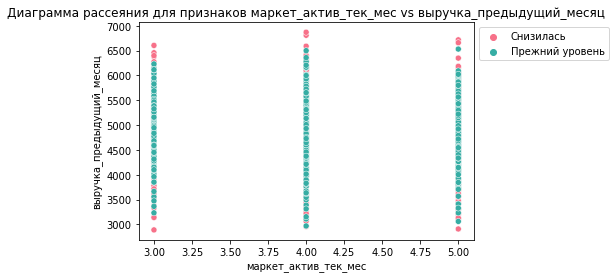

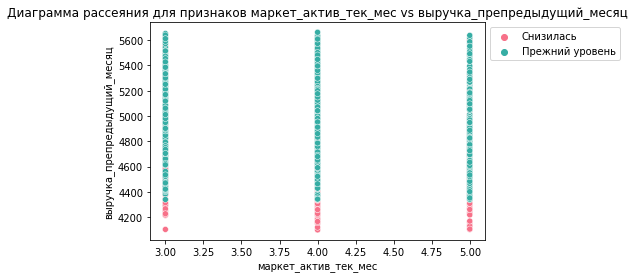

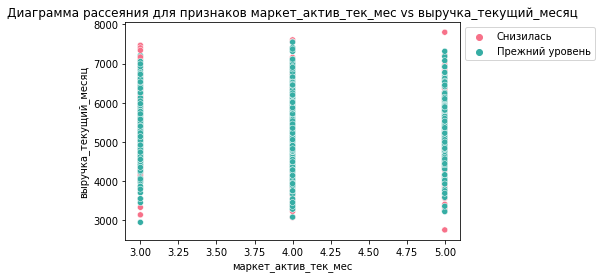

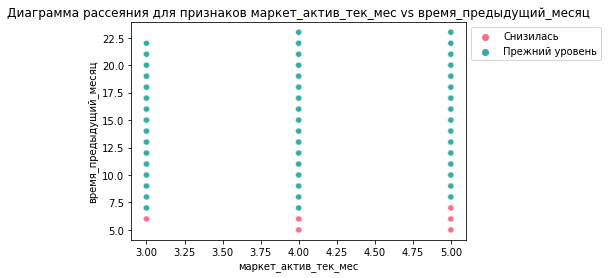

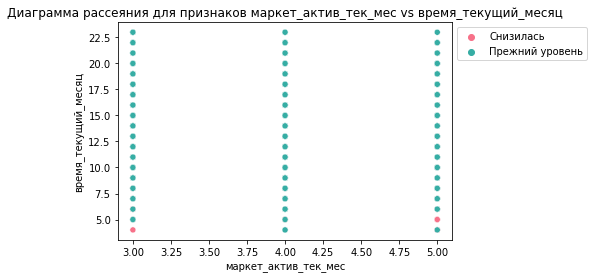

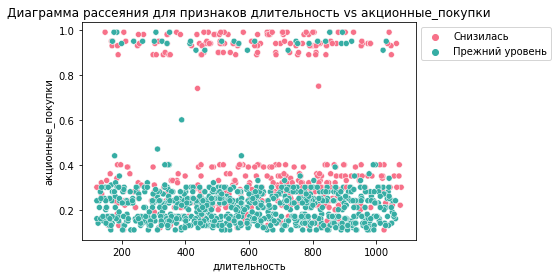

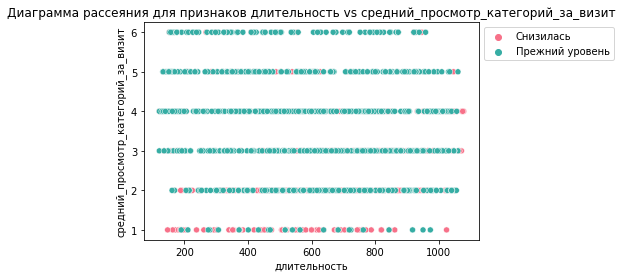

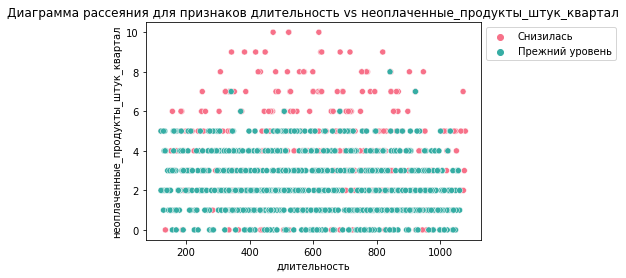

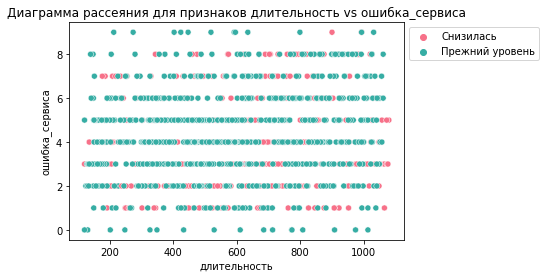

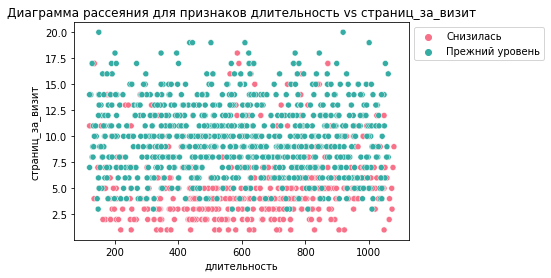

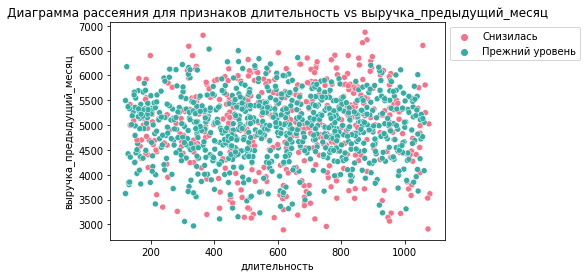

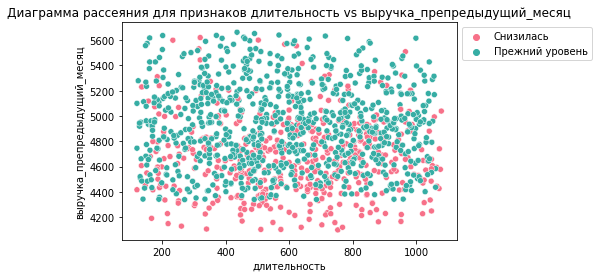

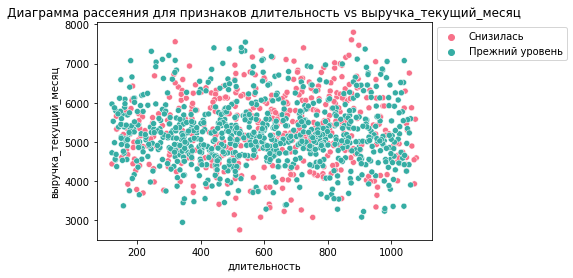

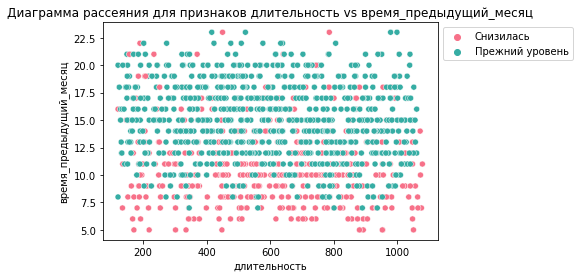

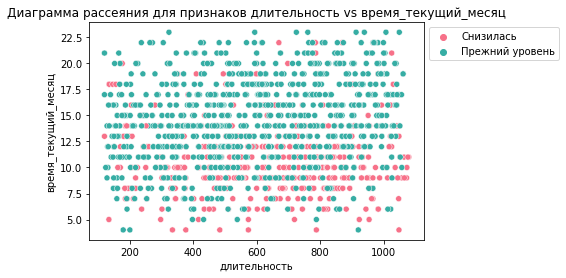

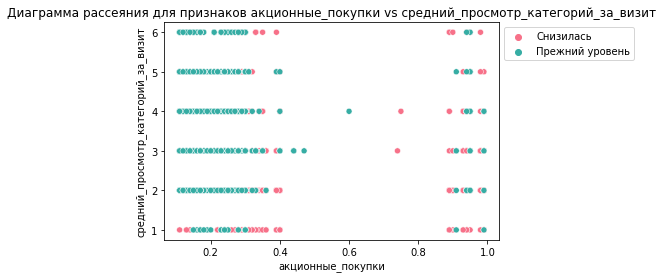

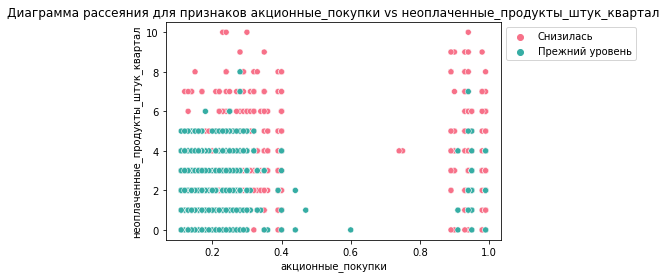

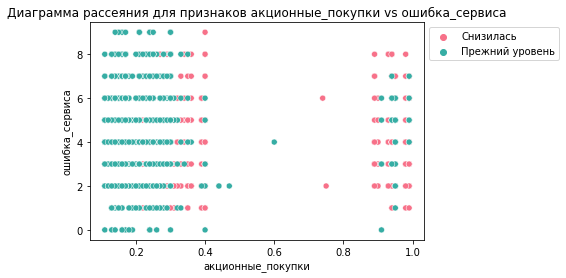

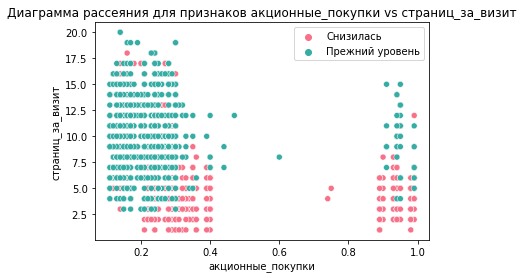

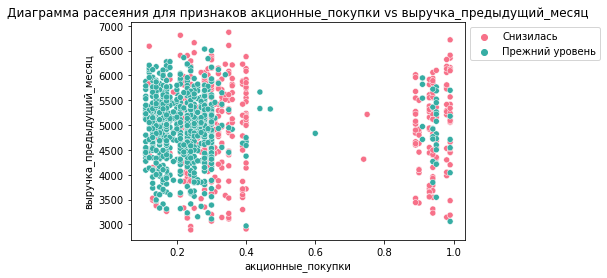

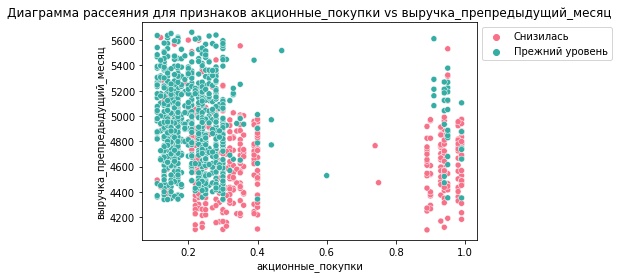

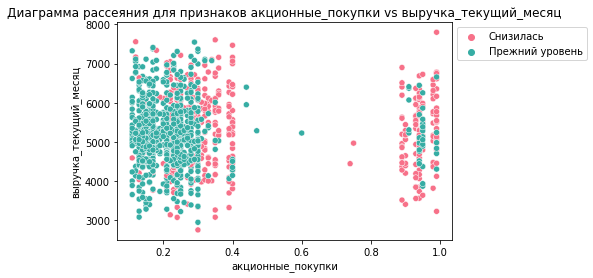

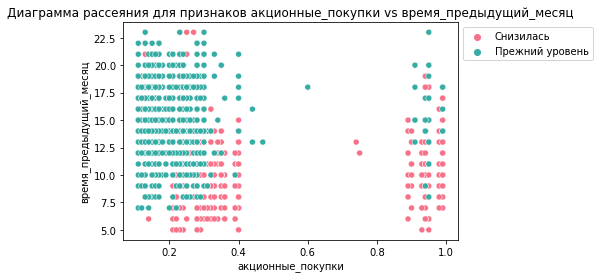

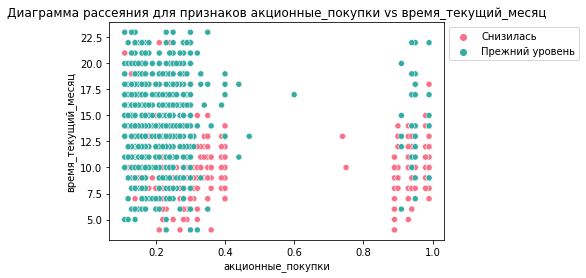

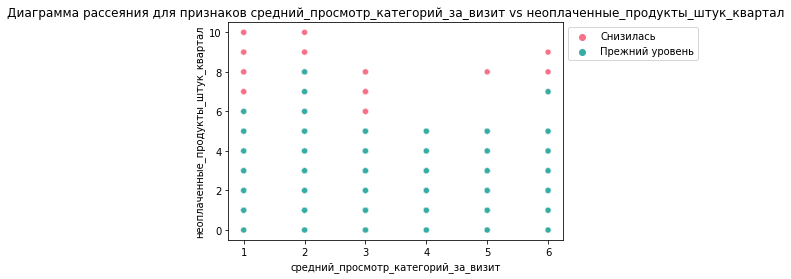

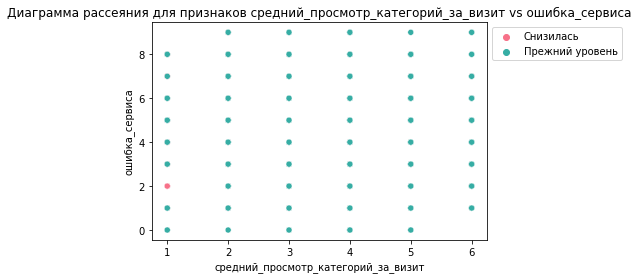

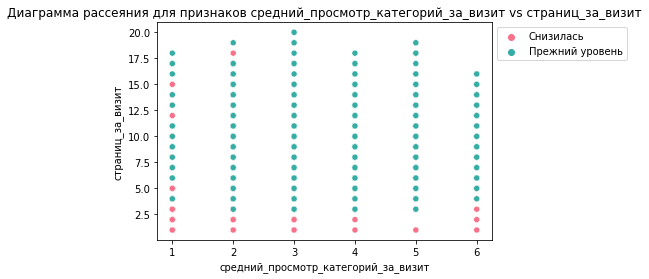

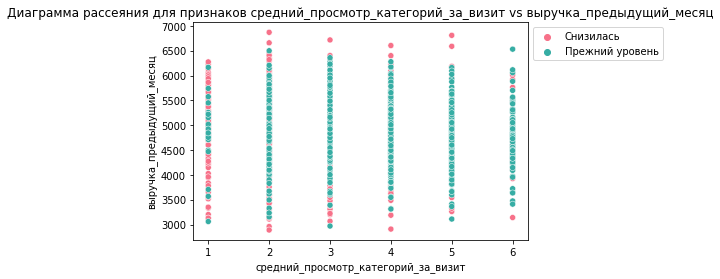

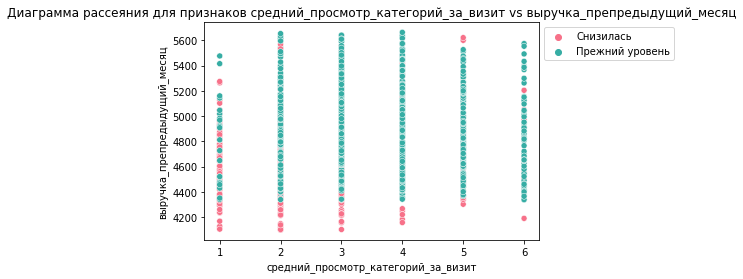

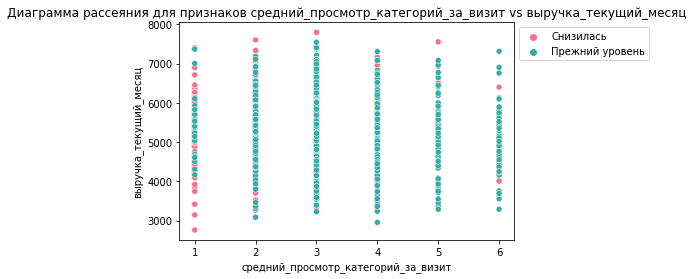

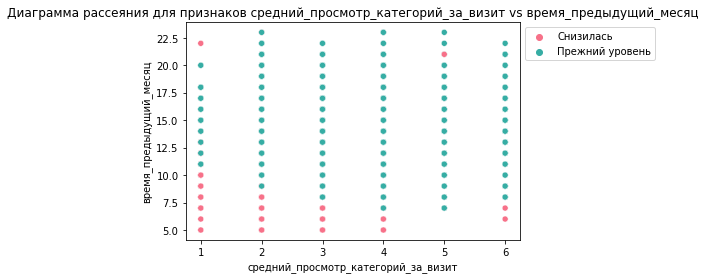

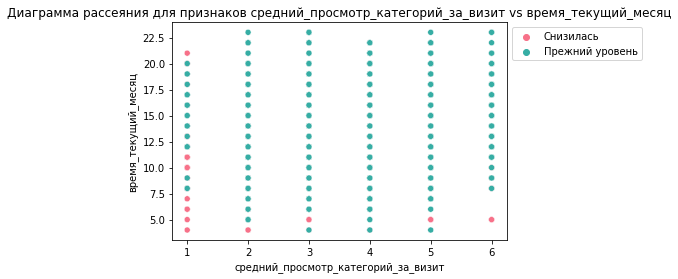

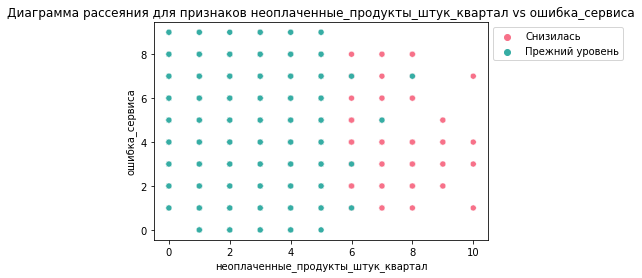

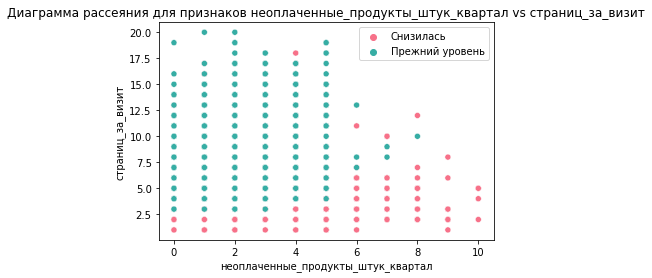

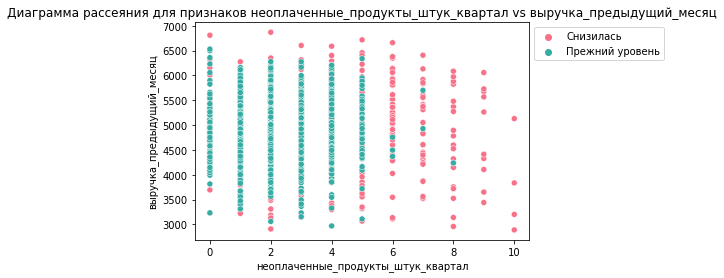

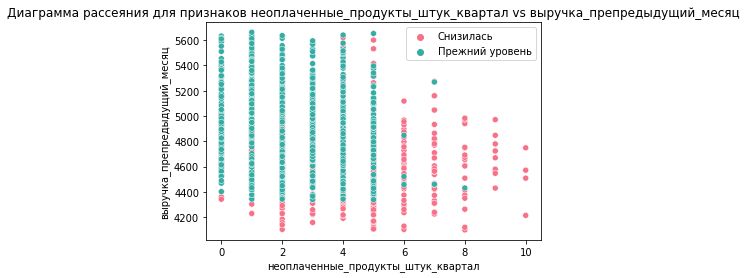

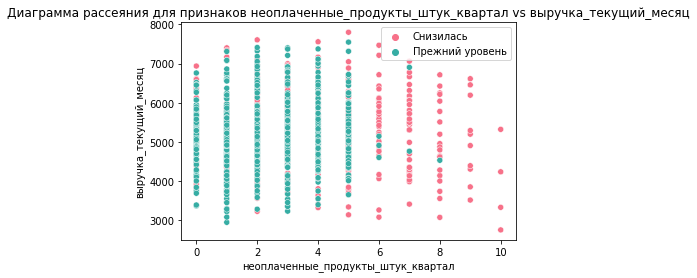

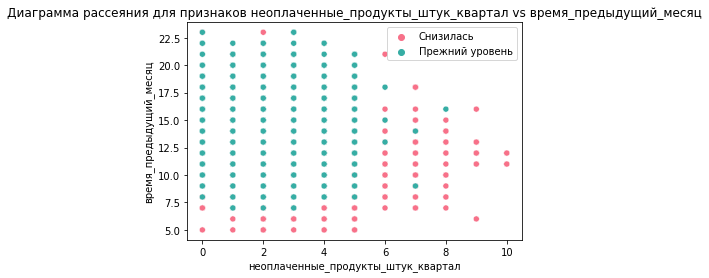

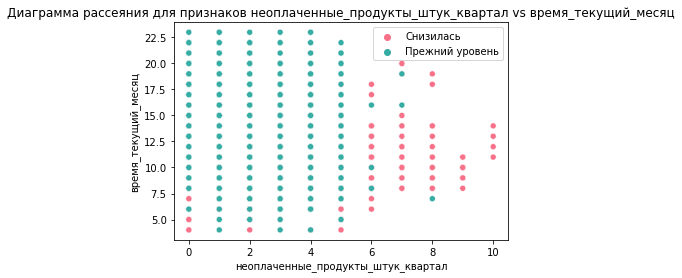

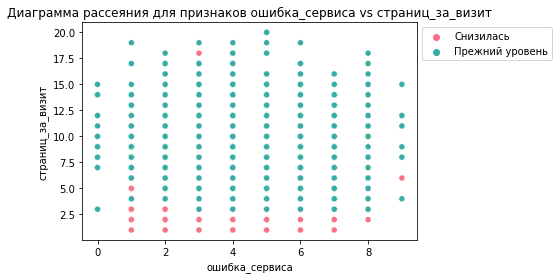

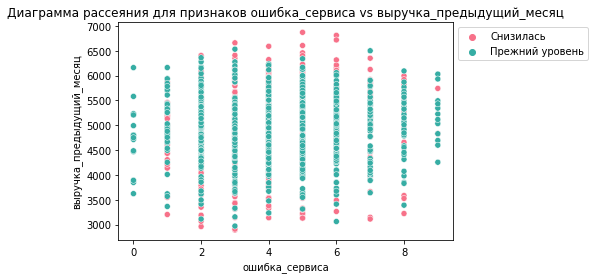

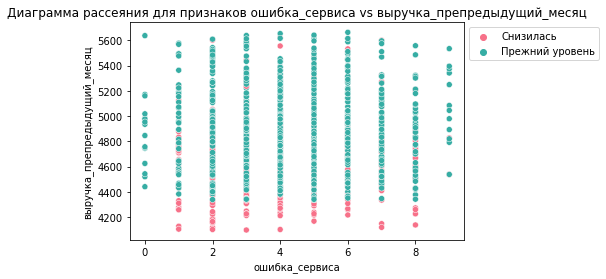

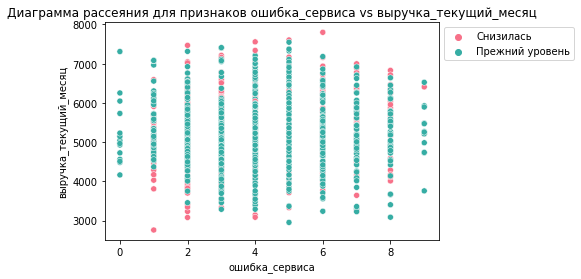

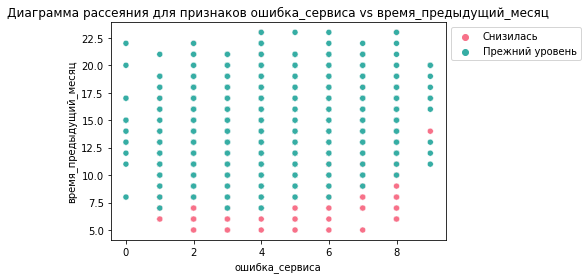

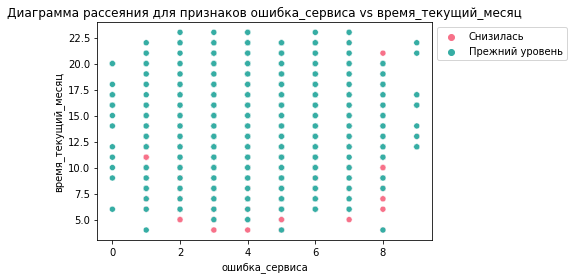

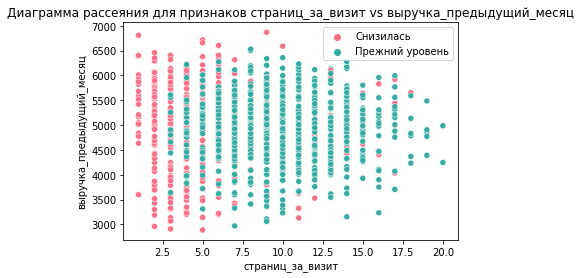

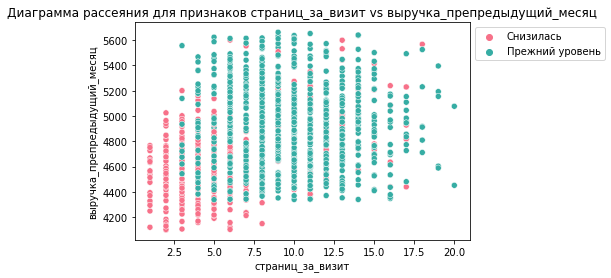

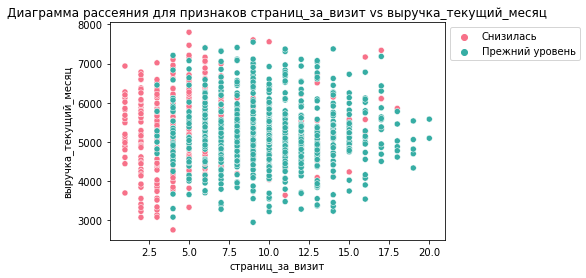

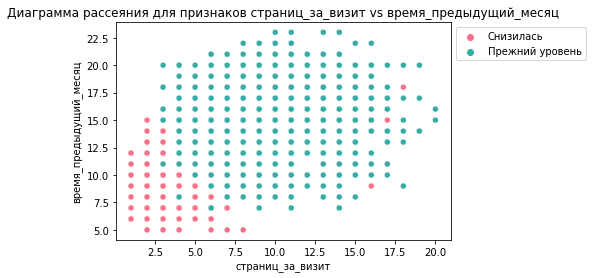

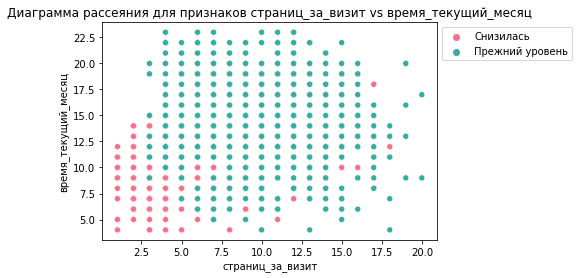

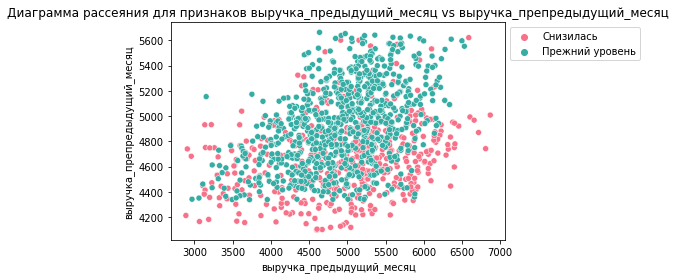

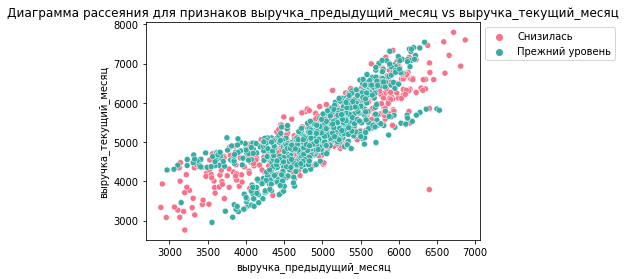

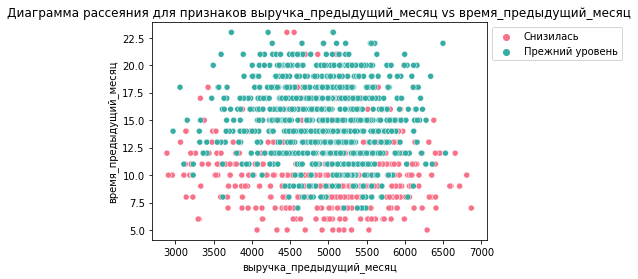

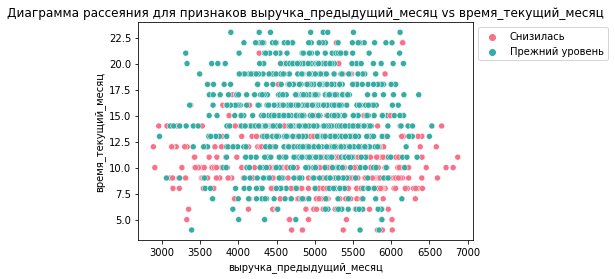

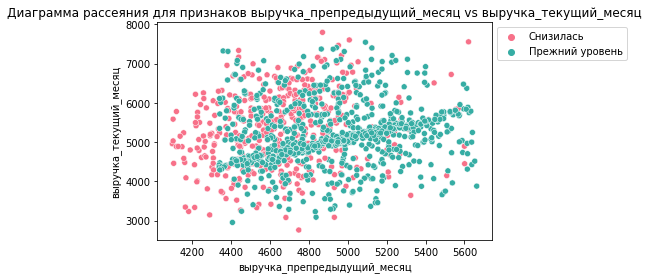

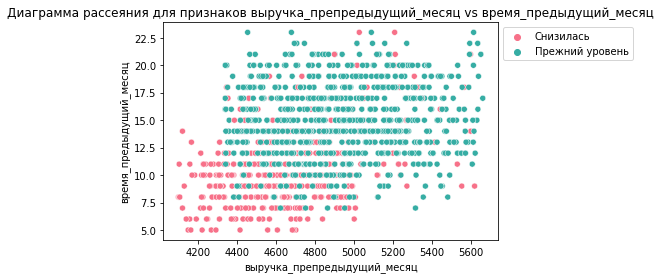

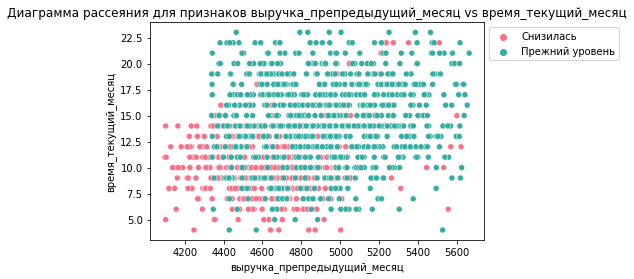

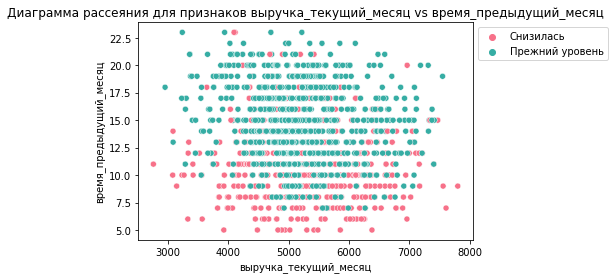

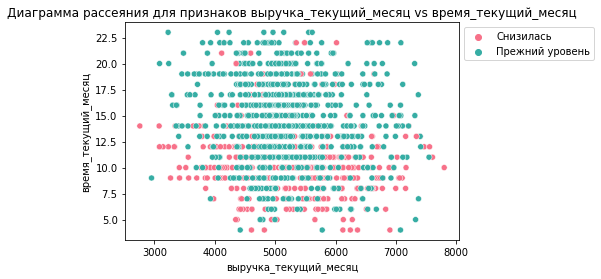

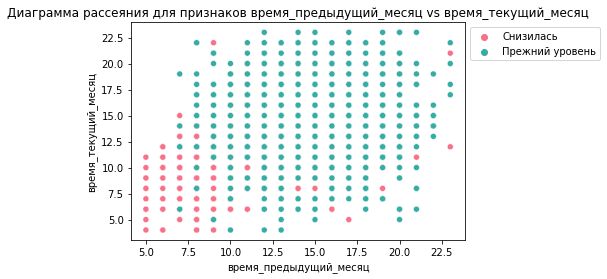

In [79]:
# Создаем комбинации из числовых признаков для построения диаграмм рассеяния
combinations = list(itertools.combinations(num_col_names, 2))

for comb in combinations:
    plt.figure()
    sns.scatterplot(data=full_data, x=comb[0], y=comb[1], hue='покупательская_активность', palette='husl')
    plt.title(f"Диаграмма рассеяния для признаков {comb[0]} vs {comb[1]}")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

__Вывод__:
- Наблюдается __высокая взаимосвязь__ целевого признака "покупательская\_активность" с признаком 'страниц\_за\_визит', __заметная взаимосвязь__ с признаками 'маркет\_актив\_6\_мес', 'маркет\_актив\_тек\_мес', 'акционные\_покупки', 'средний\_просмотр\_категорий\_за\_визит', 'неоплаченные\_продукты\_штук\_квартал', 'выручка\_препредыдущий\_месяц', 'выручка\_текущий\_месяц', 'время\_предыдущий\_месяц', 'время\_текущий\_месяц', __умеренная взаимосвязь__ с признаком 'популярная\_категория', __слабая взаимосвязь__ с признаками 'тип\_сервиса', 'длительность', 'ошибка\_сервиса', 'выручка\_предыдущий\_месяц', 'выручка\_текущий\_месяц', 'выручка'. __Взаимосвязь не выявлена__ с признаками 'разрешить\_сообщать', 'маркет\_актив\_тек\_мес'. 'id' является просто идентификатором, на целевой признак влияния оказывать не может.
- Мультиколлинеарности между входными признаками нет, однако стоит отметить __высокую взаимосвязь между признаками__ 'выручка\_текущий\_месяц' и 'выручка\_предыдущий\_месяц' (0.84).

## Использование пайплайнов

Нам нужно решить задачу  __бинарной классификации__, в которой целевой признак "покупательская\_активность", с использованием обучения с учителем. Наблюдается __дисбаланс классов__ (38.3% - "Снизилась").

### Подготовка данных

Особенности данных:
    
1. Целевой признак — "покупательская\_активность" («Снизилась» или «Прежний уровень»). 
2. Признаки для кодирования OneHotEncoder:
    - популярная_категория 
    - разрешить_сообщать
3. Признаки для кодирования OrdinalEncoder:
    - тип_сервиса
4. Признаки для масштабирования
    - 'маркет_актив\_6\_мес',
    - 'маркет_актив_тек_мес',
    - 'длительность',
    - 'акционные_покупки', 
    - 'средний_просмотр_категорий_за_визит',
    - 'неоплаченные_продукты_штук_квартал',
    - 'ошибка_сервиса',
    - 'страниц_за_визит', 
    - 'выручка_предыдущий_месяц',
    - 'выручка_препредыдущий_месяц',
    - 'выручка_текущий_месяц',
    - 'время_предыдущий_месяц', 
    - 'время_текущий_месяц'
5. Признак, который не несет смысловой нагрузки: 
    - id

Для сохранения соотношения классов получим тренировочную и тестовую выборки с помощью стратификации.

In [80]:
# создаём списки с названиями признаков
ohe_columns = ['разрешить_сообщать', 'популярная_категория']
ord_columns = ['тип_сервиса']
num_columns = num_col_names

# выделяем признаки и целевую переменную
X = full_data.drop(columns=['id', 'покупательская_активность'])
y = full_data['покупательская_активность']

# выделим выборки с учетом страт
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

X_train.shape, X_test.shape

((972, 16), (324, 16))

Т.к. у нас признаки разного типа, будем использовать класс ColumnTransformer при создании пайплайна для подготовки данных. Учтем возможное наличие пропусков и неизвестных категорий на случай, если в новых данных они появятся.

In [81]:
# SimpleImputer + OneHotEncoder
# добавляем обработку пропусков на случай, если они появятся в новых данных
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', sparse=False,  handle_unknown='ignore'))
    ]
)

# SimpleImputer + ORD + SimpleImputer
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(categories=[['стандарт', 'премиум']],
                               handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
) 

# общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder = 'passthrough'
)

### Обучение модели. Выбор лучшей модели.

Обучим 4 модели: DecisionTreeClassifier(), KNeighborsClassifier(), LogisticRegression(), SVC().

__Выбор метрики__

Для нашей задачи важно точно определить всех клиентов, чья покупательская активность снизилась, чтобы предпринять меры и их не потерять. Однако для лучшей оценки моделей  бинарной классификации с несбалансированной выборкой выберем F1-меру (будем стремиться к балансу полноты и точности) и ROC-AUC. 

Для выбора лучшей модели будем использовать один общий пайплайн для всех моделей и GridSearchCV с мультискорингом, т.к. данных у нас не так много и мы хотим учесть 2 метрики.

In [82]:
# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6), 
        'models__max_features': range(2, 14), # всего в датасете 16 признаков
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1',
        )],
        'models__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'models__class_weight': [None, 'balanced'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
        
    },

    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True, kernel='linear')],
        'models__C': [0.1, 1, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

> Выполнение следующего блока кода занимает около 12 минут.

In [83]:
# запускаем таймер
start = time.time()

grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring={
        'roc-auc': 'roc_auc',
        'f1_score': make_scorer(f1_score, pos_label='Снизилась')
    },
    refit='f1_score',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# считаем, сколько секунд прошло с начала запуска
grid_search_time = time.time() - start

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели при кросс-валидации:', grid_search.best_score_)
print ('Время поиска лучших параметров:', grid_search_time, 'секунд')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                        

In [84]:
grid_search.best_params_

{'models': SVC(C=0.1, kernel='linear', probability=True, random_state=42),
 'models__C': 0.1,
 'preprocessor__num': StandardScaler()}

Получим метрики на тестовых данных. Также определим значение метрики recall.

In [85]:
print('F1 модели на тестовой выборке:',
      f'{f1_score(y_test, grid_search.predict(X_test), pos_label="Снизилась"):.3f}')
print('ROC AUC модели на тестовой выборке:',
      f'{roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1]):.3f}')

F1 модели на тестовой выборке: 0.885
ROC AUC модели на тестовой выборке: 0.917


__Вывод__:

- Лучшие результаты показала модель SVC с параметрами kernel='linear', probability=True, random_state=42, С=0.1, при масштабировании данных с помощью стандартизации (StandardScaler).
- Метрики модели на тестовой выборке: F1 = 0.89, ROC AUC = 0.92.
- Модель хорошо балансирует между точностью и полнотой и имеет хорошую способность различать положительные и отрицательные классы. 

## Анализ важности признаков

Коэффициенты модели SVC нельзя интерпретировать (они задают уравнение гиперплоскости). Визуализируем вклад признаков в каждое предсказание модели.

In [86]:
# Извлечение модели и предобработчика из GridSearchCV
best_model = grid_search.best_estimator_.named_steps['models']
preprocessor = grid_search.best_estimator_.named_steps['preprocessor']

# Преобразование данных с использованием предобработчика
X_train_transformed = preprocessor.transform(X_train)

# Получение названий признаков для интерпретации
ohe_feature_names = preprocessor.named_transformers_['ohe'].named_steps['ohe'].get_feature_names_out()
ord_feature_names = preprocessor.named_transformers_['ord'].named_steps['ord'].get_feature_names_out()  # Необязательно X_train.columns, можно использовать любой датасет с соответствующими признаками

# Объединение названий признаков из разных трансформеров
feature_names = list(ohe_feature_names) + list(ord_feature_names) + num_columns

print('Названия признаков:')
for i in range(len(feature_names)):
    print(f'{i}: {feature_names[i]}')

Названия признаков:
0: x0_нет
1: x1_Косметика и аксесуары
2: x1_Кухонная посуда
3: x1_Мелкая бытовая техника и электроника
4: x1_Техника для красоты и здоровья
5: x1_Товары для детей
6: x0
7: маркет_актив_6_мес
8: маркет_актив_тек_мес
9: длительность
10: акционные_покупки
11: средний_просмотр_категорий_за_визит
12: неоплаченные_продукты_штук_квартал
13: ошибка_сервиса
14: страниц_за_визит
15: выручка_предыдущий_месяц
16: выручка_препредыдущий_месяц
17: выручка_текущий_месяц
18: время_предыдущий_месяц
19: время_текущий_месяц


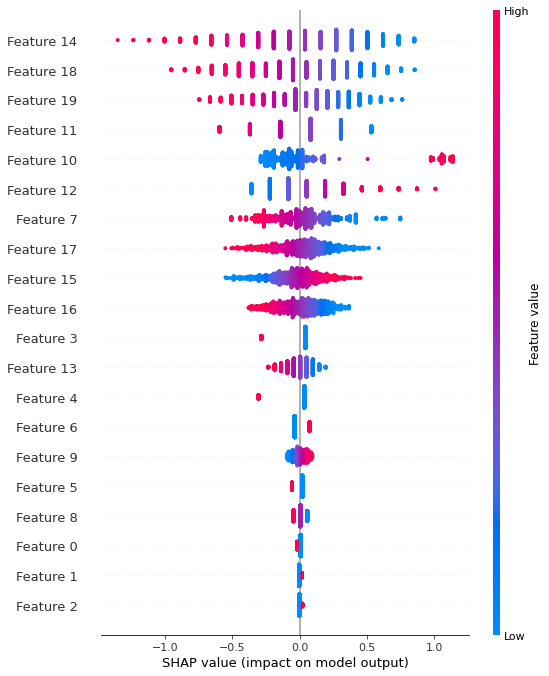

In [87]:
explainer_linear = shap.LinearExplainer(best_model, X_train_transformed)
shap_values_linear = explainer_linear.shap_values(X_train_transformed)
shap.summary_plot(shap_values_linear, X_train_transformed)

Визуализируем общий вклад признаков в прогнозы модели.

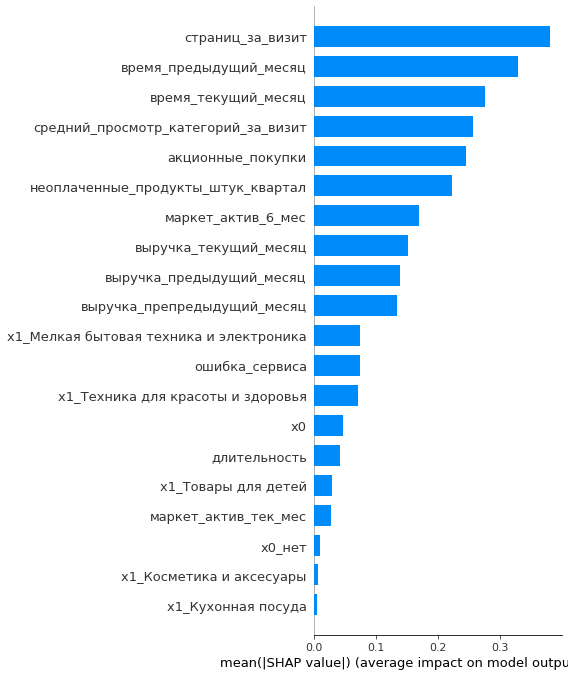

In [88]:
shap.summary_plot(shap_values_linear, X_train_transformed, plot_type="bar", feature_names=feature_names)

__Значимость признаков для модели__

- сильнее всего влияют на целевой признак (в порядке убывания влияния):
    - страниц_за_визит (меньшие значения склоняют модель к классу 'снизилась')
    - время_предыдущий_месяц (меньшие значения склоняют модель к классу 'снизилась')
    - время_текущий_месяц (меньшие значения склоняют модель к классу 'снизилась')
    - средний_просмотр_категорий_за_визит (меньшие значения склоняют модель к классу 'снизилась')
    - акционные_покупки (большие значения склоняют модель к классу 'снизилась')
    - неоплаченные_продукты_штук_квартал (большие значения склоняют модель к классу 'снизилась')
    - маркет_актив\_6\_мес(меньшие значения склоняют модель к классу 'снизилась')
    - выручка_текущий_месяц (меньшие значения склоняют модель к классу 'снизилась')
    - выручка_предыдущий_месяц (большие значения склоняют модель к классу 'снизилась')
    - выручка_препредыдущий_месяц(меньшие значения склоняют модель к классу 'снизилась')
    
- малозначимые признаки:
    - тип_сервиса
    - разрешить_сообщать
    - популярная_категория
    - маркет_актив_тек_мес
    - длительность
    - ошибка_сервиса
    - выручка_текущий_месяц

__Применение в моделировании__

Для создания модели, показывающей улучшенные результаты, можно попробовать уменьшить количество признаков за счет исключения некоторых малозначительных.

__Информация для принятия бизнес-решений__

- Посмотрим на первые 4 признака. Для увеличения количества просмотренных за визит страниц и увеличения просмотренных категорий действительно стоит использовать систему рекомендаций, не только похожие на просматриваемый товары, но и персонализированные рекомендации, учитывающие всю историю клиента, а также предлагать товары из новых категорий. Возможно, стоит уделить внимание дизайну и содержимому страниц, чтобы сделать их более привлекательными для пользователя. Это также поможет увеличить время взаимодействия с сайтом.
- Стоит проанализировать неоплаченные пользователем товары. Возможно, они давно не учавствовали в акционных предложениях, или  наблюдался резкий скачок стоимости. Выявление таких паттернов поможет подсветить проблемы с кокретными товарами. Также эту информацию можно использовать при планирования списка товаров на акции в будущих периодах.
- Необходимо найти и обеспечить оптимальное количество маркетинговых взаимодействий с клиентом, т.к. небольшое количество взаимодействий влияет на снижение покупательской активности.
- Разрешение на уведомления не оказывают большого влияния на уровень покупательской активности.
- Прогнозы модели можно учесть при планировании маркетинговых акций, при планировании бюджета на будущие периоды.

__Вывод__:
- Наибольшее влияние на целевой признак (в порядке убывания влияния) оказывают следующие признаки:
    - страниц_за_визит 
    - время_предыдущий_месяц 
    - время_текущий_месяц
    - средний_просмотр_категорий_за_визит
    - акционные_покупки
    - неоплаченные_продукты_штук_квартал 
    - маркет_актив\_6\_мес
    - выручка_текущий_месяц
    - выручка_предыдущий_месяц
    - выручка_препредыдущий_месяц
- Для создания модели, показывающей улучшенные результаты, можно попробовать уменьшить количество признаков за счет исключения некоторых малозначительных.
- Можно порекомендовать компании уделить внимание разработке или улучшению системы рекомендаций на сайте, дизайну и содержимому страниц, чтобы сделать их более привлекательными для пользователя, увеличить количество просматриваемых страниц и время взаимодействия с сайтом. Провести анализ неоплаченных пользователем товаров для выявления причин их появления, а также возможного использования информации о таких товаров для включения их в список акционных предложений будущих периодов. Уделить внимание планированию маркетинговых взаимодействий с клиентов, т.к. их количество влияет на уровень покупательской активности. Учитывать прогнозы модели при планировании маркетинговых акций, при планировании бюджета на будущие периоды.

## Сегментация покупателей

In [89]:
def plot_histogram(data, column_name, xlabel=None, ylabel='Частота', bins=100):
    """
    Функция для построения гистограммы количественного признака column_name датасета data
    """
    xlabel = column_name if xlabel is None else xlabel
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.hist(data[column_name], bins=50, color='skyblue')
    ax.set_title(f'Распределение значений признака "{column_name}"', fontsize=TITLE_SIZE)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel('Частота', fontsize=14)
    ax.grid(True)
    plt.show()

In [90]:
def plot_histogram_for_main_features(data):
    """
    Вспомогательная функция построения гистограмм для датасета data для основных признаков:
    'страниц_за_визит',
    'средний_просмотр_категорий_за_визит',
    'время_предыдущий_месяц',
    'неоплаченные_продукты_штук_квартал',
    'время_текущий_месяц',
    'акционные_покупки',
    'маркет_актив_6_мес',
    'прибыль'
    """
   
    plot_histogram(data, 'страниц_за_визит', xlabel='Количество страниц, просматриваемых за визит')
    plot_histogram(data, 'средний_просмотр_категорий_за_визит',
               xlabel='Среднее количество просматриваемых категорий за визит')
    plot_histogram(data, 'время_предыдущий_месяц', xlabel='Время, проведенное на сайте в предыдущем месяце, минут')
    plot_histogram(data, 'неоплаченные_продукты_штук_квартал',
               xlabel='Общее число неоплаченных товаров в корзине за последние 3 месяца')
    plot_histogram(data, 'время_текущий_месяц', xlabel='Время, проведенное на сайте в текущем месяце, минут')
    plot_histogram(data, 'акционные_покупки',
               xlabel='Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев')
    plot_histogram(data, 'маркет_актив_6_мес',
               xlabel='Среднемесячное значение маркетинговых коммуникаций на покупателя за последние 6 месяцев')
    plot_histogram(data, 'прибыль', 
               xlabel='Среднемесячная прибыль с покупателя за последние 3 месяца')

### Группа клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом.

Отберем пользователей, чья покупательская активность снизилась согласно предсказаниям модели. Добавим к полученному датафрейму данные о прибыльности.

In [91]:
data_reduced_activity = full_data[grid_search.predict(X) == 'Снизилась'].merge(money, on='id')
data_reduced_activity

id покупательская_активность тип_сервиса разрешить_сообщать  \
0    215349                 Снизилась     премиум                 да   
1    215351                 Снизилась    стандарт                 да   
2    215352                 Снизилась    стандарт                нет   
3    215353                 Снизилась    стандарт                 да   
4    215354                 Снизилась    стандарт                 да   
..      ...                       ...         ...                ...   
402  216607           Прежний уровень    стандарт                 да   
403  216622           Прежний уровень     премиум                 да   
404  216635           Прежний уровень    стандарт                 да   
405  216636           Прежний уровень     премиум                 да   
406  216647           Прежний уровень     премиум                 да   

     маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
0                   4.4                     4           819   
1                   3.2                     5           896   
2                   5.1                     3          1064   
3                   3.3                     4           762   
4                   5.1                     3           431   
..                  ...                   ...           ...   
402                 3.3                     4           575   
403                 4.1                     3           162   
404                 0.9                     3           932   
405                 2.4                     4           996   
406                 4.0                     5           906   

     акционные_покупки            популярная_категория  \
0                 0.75                Товары для детей   
1                 0.99                Товары для детей   
2                 0.94                Товары для детей   
3                 0.26               Домашний текстиль   
4                 0.23           Косметика и аксесуары   
..                 ...                             ...   
402               0.23                Товары для детей   
403               0.16                Товары для детей   
404               0.35           Косметика и аксесуары   
405               0.23                 Кухонная посуда   
406               0.94  Техника для красоты и здоровья   

     средний_просмотр_категорий_за_визит  неоплаченные_продукты_штук_квартал  \
0                                      4                                   4   
1                                      5                                   0   
2                                      3                                   2   
3                                      4                                   1   
4                                      2                                   3   
..                                   ...                                 ...   
402                                    2                                   4   
403                                    4                                   5   
404                                    3                                   3   
405                                    3                                   4   
406                                    4                                   5   

     ошибка_сервиса  страниц_за_визит  выручка_предыдущий_месяц  \
0                 2                 5                    5216.0   
1                 6                 4                    6158.0   
2                 3                 2                    5807.5   
3                 1                 4                    4738.5   
4                 7                 2                    5685.0   
..              ...               ...                       ...   
402               5                 8                    4991.0   
403               3                 8                    5327.5   
404               8                 5                    4452.0   
405               5                 6                    56

Выделим группу клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом.

In [92]:
buyers_tech = data_reduced_activity[(
    data_reduced_activity['популярная_категория'] == 'Мелкая бытовая техника и электроника') | 
    (data_reduced_activity['популярная_категория'] == 'Техника для красоты и здоровья')]

Возьмем 7 признаков, которые оказывают наибольшее влияние на покупательскую активность и посмотрим на них:
- страниц_за_визит
- средний_просмотр_категорий_за_визит
- время_предыдущий_месяц
- неоплаченные_продукты_штук_квартал
- время_текущий_месяц
- акционные_покупки
- маркет_актив\_6\_мес

Также добавим для анализа данные о прибыльности.

In [93]:
# для сравнения медианы прибыли и суммы прибыли по каждой категории
grouped_by_category = (
    data_reduced_activity.groupby('популярная_категория')
    .agg(медиана_прибыли=('прибыль', 'median'), сумма_прибыли=('прибыль', 'sum'))
    .sort_values(by='медиана_прибыли', ascending=False)
)
buyers_tech_sum = buyers_tech['прибыль'].sum().round(2)
buyers_tech_median = grouped_by_category['медиана_прибыли'].median().round(2)
buyers_note = pd.DataFrame(
    {'медиана_прибыли': [buyers_tech_median], 'сумма_прибыли': [buyers_tech_sum]}, 
    index=['Техника'])
(
    grouped_by_category
    .drop(index=['Техника для красоты и здоровья', 'Мелкая бытовая техника и электроника'], axis=0)
    .append(buyers_note)
    .sort_values(by='медиана_прибыли', ascending=False)
)


медиана_прибыли  сумма_прибыли
Косметика и аксесуары            4.190         380.64
Товары для детей                 4.170         506.17
Техника                          4.100         209.49
Кухонная посуда                  3.985         252.64
Домашний текстиль                3.910         289.62

In [94]:
columns_to_analyze = ['страниц_за_визит', 'средний_просмотр_категорий_за_визит',
                   'время_предыдущий_месяц', 'неоплаченные_продукты_штук_квартал',
                   'время_текущий_месяц', 'акционные_покупки', 'маркет_актив_6_мес', 'прибыль']
buyers_tech[columns_to_analyze].describe().T

count       mean       std   min     25%  \
страниц_за_визит                      52.0   4.519231  2.305070  1.00  3.0000   
средний_просмотр_категорий_за_визит   52.0   2.365385  1.155190  1.00  1.0000   
время_предыдущий_месяц                52.0  10.730769  2.737649  5.00  9.0000   
неоплаченные_продукты_штук_квартал    52.0   4.576923  2.674104  1.00  2.0000   
время_текущий_месяц                   52.0  10.615385  2.780562  5.00  9.0000   
акционные_покупки                     52.0   0.517115  0.318959  0.17  0.2475   
маркет_актив_6_мес                    52.0   3.661538  1.157101  0.90  3.2500   
прибыль                               52.0   4.028654  0.901850  1.68  3.3175   

                                        50%      75%    max  
страниц_за_визит                      4.000   5.0000  12.00  
средний_просмотр_категорий_за_визит   2.000   3.0000   6.00  
время_предыдущий_месяц               11.000  12.0000  18.00  
неоплаченные_продукты_штук_квартал    4.000   7.0000  10.00  
время_текущий_месяц                  10.000  13.0000  18.00  
акционные_покупки                     0.340   0.9300   0.99  
маркет_актив_6_мес                    3.900   4.4000   5.60  
прибыль                               4.065   4.6875   6.27

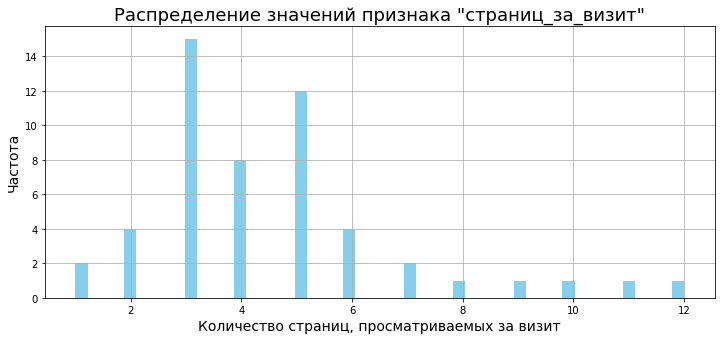

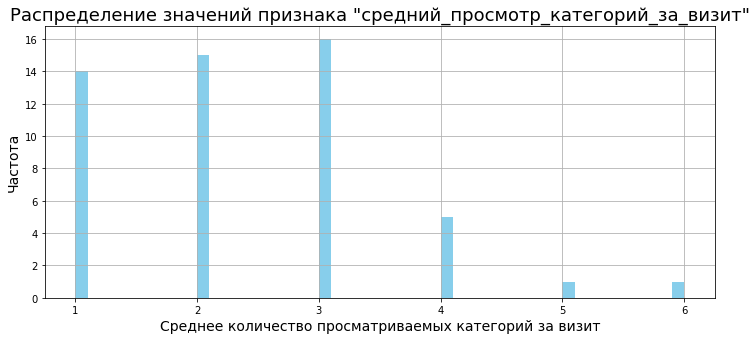

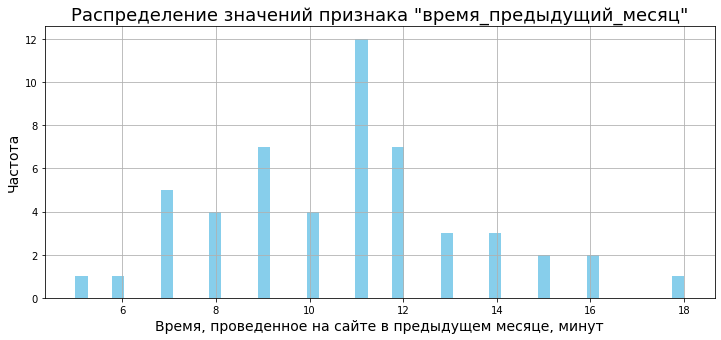

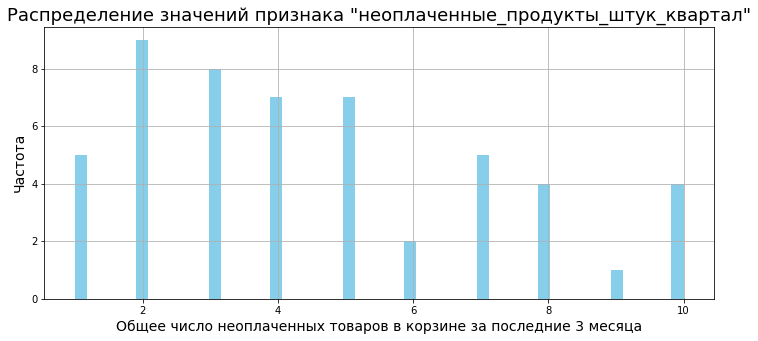

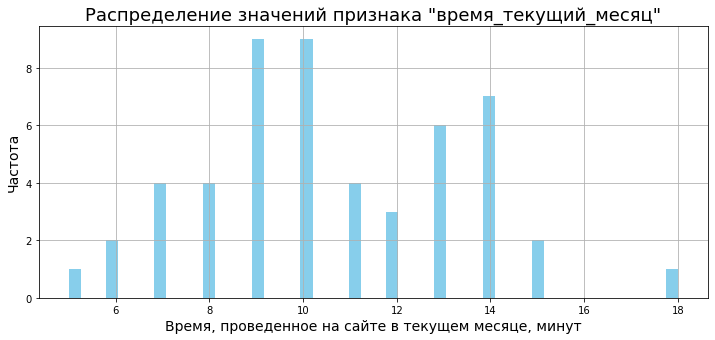

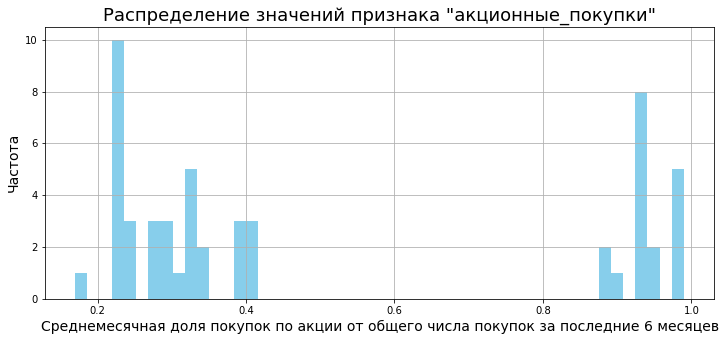

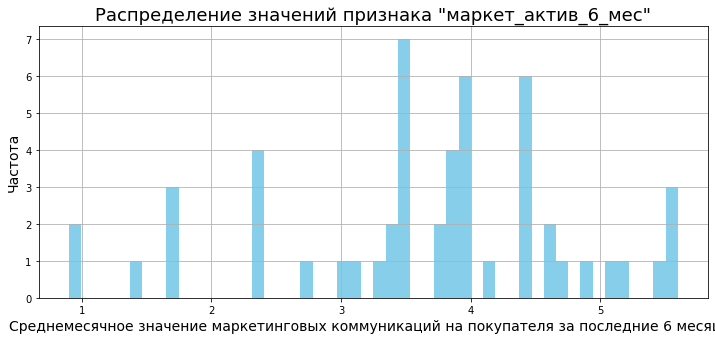

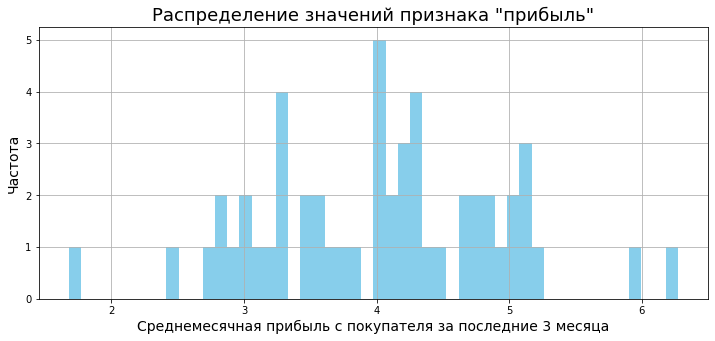

In [95]:
plot_histogram_for_main_features(buyers_tech)

Прибыль по данному сегменту за последние 3 месяца составляет 209.49. Медианное значение прибыли с клиента - 4.1. 

Обратим внимание на медианные значения и межквартильный размах:
1) Клиенты данного сегмента за визит просматривают 4 страницы, 2 категории. 
> В целом по датасету для среднего количества страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца, межквартильный размах - от 5 до 11, медиана - 8.

2) Время взаимодействия с сайтом в месяц - 11 минут за предыдущий, 10 минут - за текущий месяц.

3) Доля покупок по акции - 0.34.  Широкие границы межквартильного размаха - от 0.24 до 0.93. Выделяется группа покупателей с очень высоким значением доли покупок по акции.
> В целом по датасету межквартильный размах от 0.17 до 0.3, медиана - 0.24

4) За последние 3 месяца число неоплаченных продуктов в корзине составляет 4 штуки, межквартильный размах - от 2 до 7.
> В целом по датасету межквартильный размах - от 1 до 4,  медиана - 3. 

5) Среднемесячное число маркетинговых взаимодействий - около 3.9. 


Выводы и предложения:
- Стоит проработать и по возможности сделать более привлекательным для пользователя контент категорий 'Техника для красоты и здоровья', 'Мелкая бытовая техника и электроника'. 
- Для увеличения количества просматриваемых категорий, а также количества страниц за визит и времени взаимодействия с сайтом нужно проработать персонализированную рекламу для популярных категорий, а также систему рекомендаций для смежных категорий (например, при покупке техники для красоты предлагать товары из категории 'Косметика и аксесуары', которые чаще всего покупают с этой техникой, при покупке бытовой техники предлагать купить что-нибудь из категории 'Кухонная посуда', также некоторые товары из выделенных категорий могут свидетельствовать о наличии детей, соответственно, можно предложить купить что-либо из категории 'Товары для детей' либо кухонную посуду для детей).
- Пользователи данного сегмента пользуются акциями, это также можно использовать. Также стоит отметить, что выделяется часть покупателей, которые активно покупают по большей части акционные товары. Предлагать акции на товар из популярных категорий + товар из смежной категории, которая может заинтересовать пользователя (примеры самых очевидных сочетаний есть выше: техника для красоты и здоровья + косметика и аксесуары, мелкая бытовая техника + кухонная посуда, техника для здоровья(то, что чаще покупается для детей: небулайзер, детский термометр) + товары для детей(игрушка из списка предложенных простимулирует покупателей посмотреть несколько страниц из нетипичной категории) + кухонная посуда(для детей, это может быть какой-то мелкий недорогой товар в подарок).
- У пользователей много неоплаченных товаров в корзине. Стоит рассмотреть возможность персонализированных скидок на товары в корзине. Также можно отправлять напоминания о том, что в корзине все еще остались товары.
- Можно рассмотреть предоставление скидок на покупку товаров из смежных категорий после покупки техники.  
- Стоит рассмотреть возможность увеличения числа взаимодействий с клиентами для информирования их о новых акциях  и скидках.

### Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.

Выберем клиентов с высокой вероятностью снижения покупательской активности. Для этого получим предсказания вероятностей для класса 1 (снижение покупательской активности) и оставим только тех клиентов, у которых вероятность больше, чем 0.9. Добавим данные о прибыльности.

In [96]:
data_reduced_activity_act = full_data[grid_search.predict_proba(X)[:, 1] > 0.9].merge(money, on='id')

# узнаем значения для доли акционных покупок
data_reduced_activity_act['акционные_покупки'].value_counts().sort_index(ascending=False)

0.99    15
0.98    15
0.95     6
0.94    28
0.93    14
0.90    10
0.89    15
0.75     1
0.40    10
0.39     7
0.36     6
0.35     8
0.34     2
0.33     5
0.32    10
0.31     5
0.30    10
0.29     6
0.28    11
0.27     3
0.25     5
0.24     7
0.23     5
0.22    12
0.21     3
0.14     1
Name: акционные_покупки, dtype: int64

Стоит отнести к данному сегменту пользователей, доля акционных покупок у которых от 0.89 и выше.

In [97]:
data_reduced_activity_act = data_reduced_activity_act[data_reduced_activity_act['акционные_покупки'] >= 0.89]
data_reduced_activity_act

id покупательская_активность тип_сервиса разрешить_сообщать  \
1    215352                 Снизилась    стандарт                нет   
3    215364                 Снизилась     премиум                 да   
4    215365                 Снизилась    стандарт                 да   
5    215373                 Снизилась     премиум                нет   
6    215374                 Снизилась    стандарт                нет   
..      ...                       ...         ...                ...   
210  215735                 Снизилась     премиум                нет   
214  215741                 Снизилась    стандарт                 да   
217  215745                 Снизилась    стандарт                 да   
218  215747                 Снизилась    стандарт                 да   
219  215910                 Снизилась    стандарт                нет   

     маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
1                   5.1                     3          1064   
3                   4.3                     4           708   
4                   3.9                     4           167   
5                   3.8                     3           811   
6                   2.9                     5           268   
..                  ...                   ...           ...   
210                 4.6                     4           511   
214                 4.8                     4           563   
217                 1.7                     4           550   
218                 3.5                     5           452   
219                 3.9                     3           509   

     акционные_покупки                  популярная_категория  \
1                 0.94                      Товары для детей   
3                 0.98                     Домашний текстиль   
4                 0.95        Техника для красоты и здоровья   
5                 0.90                      Товары для детей   
6                 0.98                     Домашний текстиль   
..                 ...                                   ...   
210               0.99                 Косметика и аксесуары   
214               0.94                      Товары для детей   
217               0.94  Мелкая бытовая техника и электроника   
218               0.93                      Товары для детей   
219               0.95                 Косметика и аксесуары   

     средний_просмотр_категорий_за_визит  неоплаченные_продукты_штук_квартал  \
1                                      3                                   2   
3                                      3                                   3   
4                                      6                                   4   
5                                      2                                   5   
6                                      6                                   3   
..                                   ...                                 ...   
210                                    2                                   2   
214                                    1                                   5   
217                                    4                                   1   
218                                    1                                   5   
219                                    2                                   6   

     ошибка_сервиса  страниц_за_визит  выручка_предыдущий_месяц  \
1                 3                 2                    5807.5   
3                 3                 3                    5795.5   
4                 2                 5                    4577.0   
5                 5                 3                    4632.0   
6                 2                 2                    5762.5   
..              ...               ...                       ...   
210               5                 4                    6094.5   
214               7                 4                    3960.0   
217               3                 6                 

В данном сегменте мы определили 103 покупателей. Получим описание данных, построим графики и проведем анализ. Будем учитывать 7 основных признаков, как и для предыдущего сегмента.

In [98]:
full_data[['страниц_за_визит', 'средний_просмотр_категорий_за_визит', 'время_предыдущий_месяц',
 'неоплаченные_продукты_штук_квартал', 'время_текущий_месяц', 'акционные_покупки',
 'маркет_актив_6_мес']].describe().T

count       mean       std   min    25%  \
страниц_за_визит                     1296.0   8.187500  3.978459  1.00   5.00   
средний_просмотр_категорий_за_визит  1296.0   3.267747  1.355125  1.00   2.00   
время_предыдущий_месяц               1296.0  13.470679  3.937630  5.00  10.75   
неоплаченные_продукты_штук_квартал   1296.0   2.841821  1.974074  0.00   1.00   
время_текущий_месяц                  1296.0  13.210648  4.221794  4.00  10.00   
акционные_покупки                    1296.0   0.320069  0.249159  0.11   0.17   
маркет_актив_6_мес                   1296.0   4.256404  1.013525  0.90   3.70   

                                       50%   75%    max  
страниц_за_визит                      8.00  11.0  20.00  
средний_просмотр_категорий_за_визит   3.00   4.0   6.00  
время_предыдущий_месяц               13.00  17.0  23.00  
неоплаченные_продукты_штук_квартал    3.00   4.0  10.00  
время_текущий_месяц                  13.00  16.0  23.00  
акционные_покупки                     0.24   0.3   0.99  
маркет_актив_6_мес                    4.20   4.9   6.60

In [99]:
data_reduced_activity_act[columns_to_analyze].describe().T

count      mean       std   min   25%  \
страниц_за_визит                     103.0  3.912621  1.615530  1.00  3.00   
средний_просмотр_категорий_за_визит  103.0  2.407767  1.097563  1.00  2.00   
время_предыдущий_месяц               103.0  9.582524  2.320092  5.00  8.00   
неоплаченные_продукты_штук_квартал   103.0  4.475728  2.408501  0.00  3.00   
время_текущий_месяц                  103.0  9.844660  2.316849  4.00  8.00   
акционные_покупки                    103.0  0.941165  0.033848  0.89  0.93   
маркет_актив_6_мес                   103.0  3.372816  1.039060  0.90  2.90   
прибыль                              103.0  3.878155  0.925417  1.63  3.21   

                                       50%     75%    max  
страниц_за_визит                      4.00   5.000   8.00  
средний_просмотр_категорий_за_визит   2.00   3.000   6.00  
время_предыдущий_месяц                9.00  11.000  16.00  
неоплаченные_продукты_штук_квартал    4.00   6.000  10.00  
время_текущий_месяц                  10.00  11.000  17.00  
акционные_покупки                     0.94   0.980   0.99  
маркет_актив_6_мес                    3.60   4.100   5.10  
прибыль                               4.01   4.445   6.73

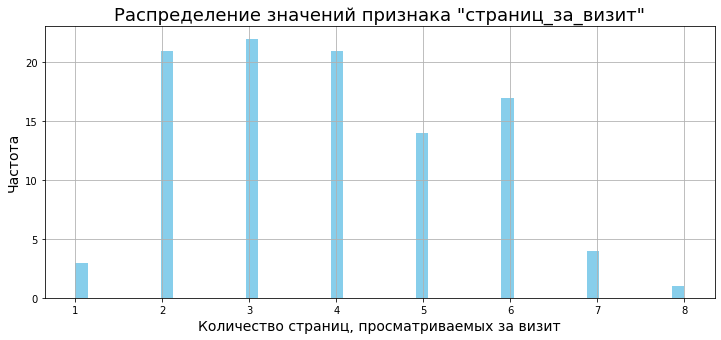

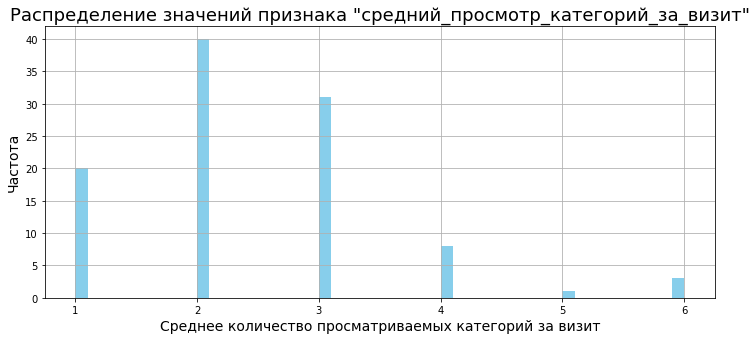

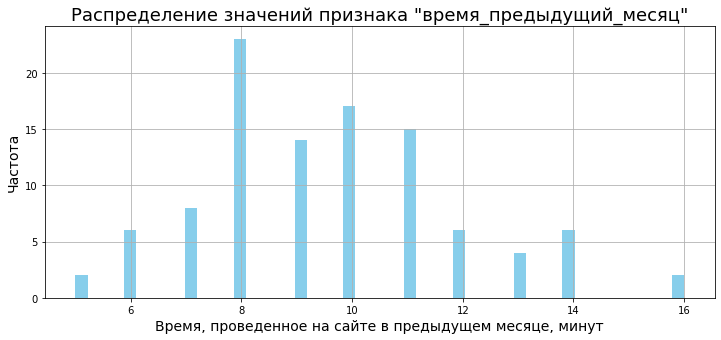

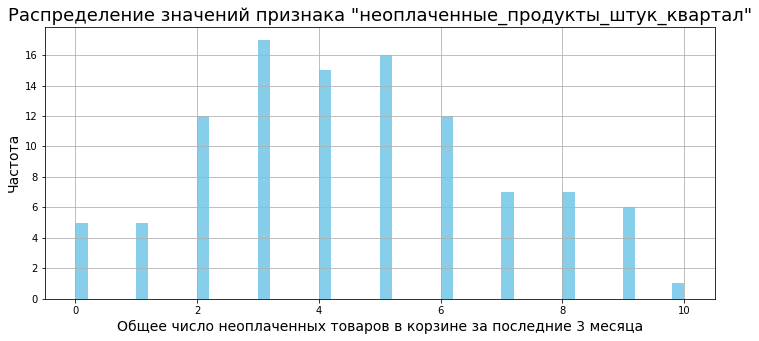

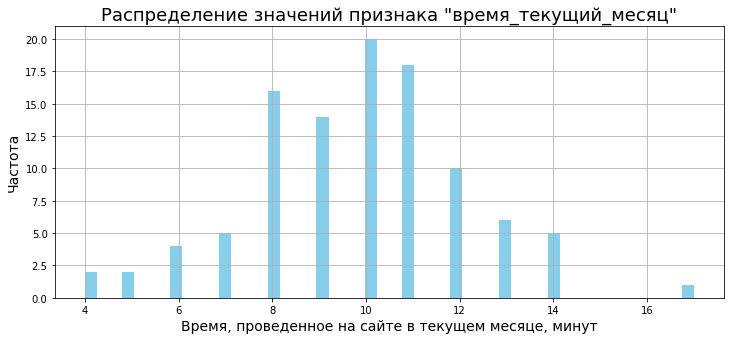

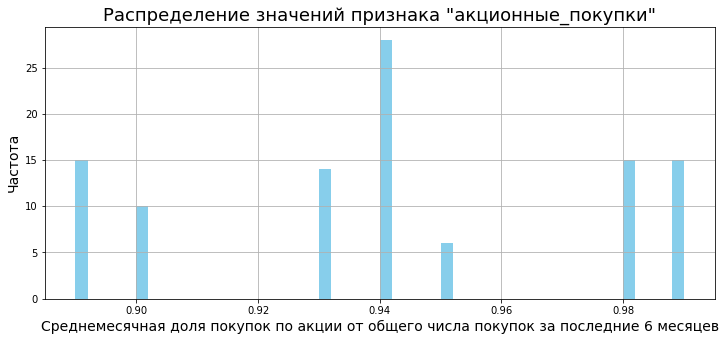

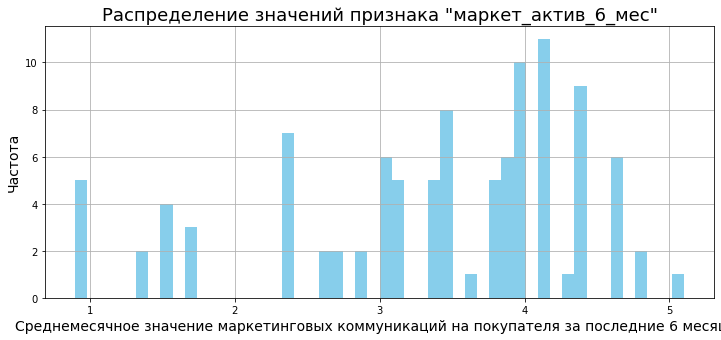

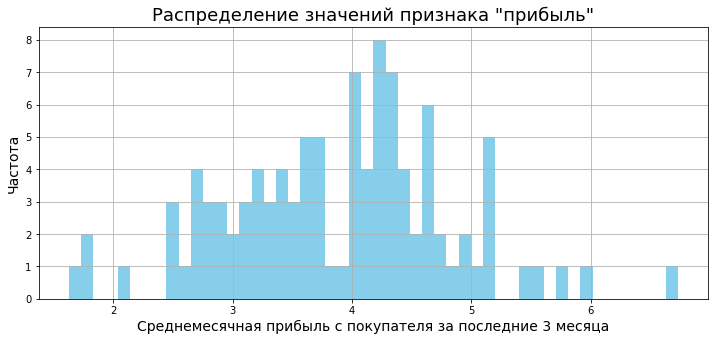

In [100]:
plot_histogram_for_main_features(data_reduced_activity_act)

In [101]:
print(f'Медианное значение прибыли: {data_reduced_activity_act["прибыль"].median()}') 
print(f'Суммарное значение прибыли: {data_reduced_activity_act["прибыль"].sum()}')

Медианное значение прибыли: 4.01
Суммарное значение прибыли: 399.45


Прибыль по данному сегменту за последние 3 месяца составляет 399.45. Медианное значение прибыли с клиента - 4.01. 

Обратим внимание на медианные значения и межквартильный размах:
1) Клиенты данного сегмента за визит просматривают 4 страницы, 2 категории. Количество просматриваемых страниц гораздо меньше значения по датасету в целом. Это может свидетельствовать о небольшой доле акционных предложений на сайте, либо о недостатках в навигационной системе сайта, недостаточно хорошей системе показа рекламы товаров на скидках.

2) С учетом малого количества просматриваемых страниц, время взаимодействия с сайтом также ниже, чем по датасету в целом.

3) Доля покупок по акции очевидно высокая, т.к. это был один из критериев формирования сегмента.

4) Межквартильный размах и медианное значение числа неоплаченных продуктов также имеют более высокие значения. Это может быть связано с разными причинами: пользователь мог передумать, либо хотел купить по акции, а она завершилась до оплаты. 

5) Среднемесячное число маркетинговых взаимодействий меньше, чем по датасету в целом. 

Рекомендации:

- Проработать навигацию на сайте, ускорить доступ пользователя к просмотру товаров на акциях.
- Использовать баннеры, всплывающие окна и другие элементы, информирующие пользователя о проходящих и будущих акциях, сделать такую рекламу более заметной для данной категории пользователей. 
- Предусмотреть для пользователя возможность отмечать товары для получения уведомления при возможном участии товара в акции. Это простимулирует его просматривать не только акционный контент.
- Информировать пользователя о проведении акции на товары, которые он отметил, товары, которые ему понравились (если такой функционал есть на сайте), на товары, которые им недавно просматривались. 
- Использовать персонализированные рекомендации акционных товаров на основе предыдущих покупок.
- Отправлять уведомления о товарах в корзине, об акционных предложениях на неоплаченные товары. Информировать пользователя о скором завершении акции на товар, оставленный в корзине.
- Для данной категории пользователей также можно предусмотреть введение акций на комбо товаров из разных категорий.

__Вывод__:

- Мы выделили для анализа 2 сегмента пользователей: пользователей, покупающих технику, со сниженной покупательской активностью, и пользователей с высокой долей покупок на акциях и высокой вероятностью снижения покупательской активности.
- Рекомендации для пользователей, покупающих технику, связаны с проработкой контента сайта и улучшением системы рекомендаций товаров из смежных категорий. Также стоит формировать акционные предложения на технику + товары из смежных категорий. Таким пользователям можно предлагать персонализированные скидки на товары в корзине, отправлять напоминания о том, что в корзине все еще остались товары, предлагать скидки на покупку товаров из смежных категорий после покупки техники. Стоит увеличить число взаимодействий с клиентами для информирования их о новых акциях и скидках.
- Рекомендации для пользователей с высокой долей покупок на акции включают в себя улучшение навигации сайта и персонализированный показ рекламных сообщений о проходящих акциях для создания простого пути просмотра большего количества интересующего пользователя контента. Также стоит для пользователя создать возможность отмечать товары для получения уведомления при возможном участии товара в акции. Стоит использовать персонализированные рекомендации акционных товаров на основе предыдущих покупок. Увеличить число взаимодействий с пользователем, отправлять уведомления о товарах в корзине, об акционных предложениях на неоплаченные товары, сообщать о скором завершении акции на товары в корзине. Можно изучить, будут ли привлекательны для таких пользвателей акции на комбо товаров из разных категорий.

## Общий вывод

Мы работали с данными интернет-магазина «В один клик», которые были предоставлены в 4 таблицах: данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении, данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом, данные о времени, которое покупатель провёл на сайте в течение периода, данные о среднемесячной прибыли покупателя за последние 3 месяца.

Мы __загрузили данные для исследования__, убедились, что данные загрузились корректно и соответствуют описанию, пропуски отсутствуют. В категориальных данных присутствовали опечатки, не соблюдался змеиный регистр в наименовании столбцов.

Во время __предобработки данных__ привели названия столбцов в соответствие со змеиным стилем, выполнили предварительную проверку на явные дубликаты, проверку на дубликаты по ключевым столбцам, исправили опечатки в значениях категориальных столбцов; повторно убедились в отсутствии дубликатов.

Провели __исследовательский анализ данных__.
- __Целевой признак__ - класс покупательской активности. В предоставленном датасете наблюдаем, что активность 38.3% покупателей снизилась. Имеем дело с дисбалансом классов.
- Признаки, характеризующие __коммуникацию с клиентом__:
    - В предоставленных данных преобладают клиенты с уровнем обслуживания "стандарт" (71.1%). 74% покупателей дали согласие на рассылку дополнительных предложений. Вместе с тем, покупатели с уровнем обслуживания 'премиум' чаще соглашались на рассылку: 86.97% против 68.72%. Среди пользователей с уровнем обслуживания "стандарт" наблюдается снижение покупательской активности у 35.5% покупателей, среди пользователей с уровнем обслуживания "премиум" - 45.21%. Снижение уровня покупательской активности среди тех, кто получает уведомления о новых предложениях, и тех, кто от них отказался, практически одинаковый - 38.57% и 37.57%.
    - Значения признака "маркет_актив\_6\_мес" распределены в диапазоне от 0.9 до 6.6. Медианное значение - 4.2, среднее довольно близко к медианному - 4.25. Стандартное отклонение - 1.01. Границы межквартильного размаха - от 3.7 до 4.9. Часть наблюдений опредлена как выбросы (меньше 2 маркетинговых коммуникаций за 6 месяцев). Вместе с тем, эти значения не являются аномальными, оставим их. К тому же, если рассмотреть их вместе с целевым признаком, почти у всех покупателей наблюдалось снижение покупательской активности.
    - Количество маркетинговых коммуникаций в текущем месяце лежит в диапазоне от 3 до 5, более половины значений - 4 взаимодействия (межквартильный размах - от 4 до 4), мода и медиана равны 4, среднее взначение - 4.01, стандартное отклонение - 0.7. Учитывая небольшой разброс, можно говорить о стабильности коммуникаций в текущем месяце. 
    - Значения признака "длительность" распределены в диапазоне от 110 до 1079 дней. Медианное значение - 606, среднее довольно близко к медианному - 601.9. Стандартное отклонение - 249.86 дней. Границы межквартильного размаха - от 405.5 до 806 дней. Выбросов нет.
    - У пользователей, чья покупательская активность снизилась, медианное количество дней с момента регистрации на сайте немного больше, чем у тех, чья покупательская активность прежняя - 634.5 и 590 соответственно. Медианное количество коммуникаций за 6 месяцев у этой группы меньше- 3.9 против 4.4. Медианное количество коммуникаций в текущем месяце одинаковое - 4.
    
- Признаки, характеризующие __продуктовое поведение__:
    - Наиболее частой категорией продукта в заказе является категория "Товары для детей" не зависимо от покупательской активности. Также в тройке самых популярных категории "Домашний текстиль" и "Косметика и аксесуары". Пользователи с уровнем сервиса "стандарт" больше интересуются категорией "Товары для детей" и "Косметика и аксесуары", а с уровнем "стандарт" - "Товары для детей" и "Домашний текстиль".
    - Среднее число просматриваемых категорий продуктов за визит находится в диапазоне от 1 до 6, межквартильные размах - от 2 до 4. Стандартное отклонение составляет 1.36. Среднее значение близко к медианному и равно 3.27, медиана равна 3. Выбросов нет.
    - Число неоплаченных продуктов в корзине за последние три месяца принимает значения от 0 до 10, межквартильный размах - от 1 до 4. Стандартное отклонение - 1.97. Среднее значение - 2.84, медиана - 3. Выбросов нет. Значения 9 и 10 являются редкими для датасета.
    - Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев лежит в диапазоне от 0 до 0.99, межквартильный размах от 0.17 до 0.3. Стандартное отклонение - 0.25. Среднее значение превышает медианное: 0.32 и 0.24 соответственно. На среднее значение влияют значения, превышающие 0.5, которые на диаграмме размаха определены как выбросы.
    - У покупателей, чья активность снизилась, медианное количество просмотров категорий за визит составляет 2, а число неоплаченных продуктов за последний квартал - 4, в то время как у покупателей с прежним уровнем активности - 4 категории и 2 продукта соответственно. Медианное значение доли покупок по акции у покупателей, чья активность снизилась, больше и составляет 0.31 против 0.21. Если рассматривать пользователей с разным типом сервиса, то медианные значения перечисленных выше параметров для них одинаковые.

- Признаки, характеризующие __поведение на сайте__:
    - Значения среднего количества страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца, лежат в диапазоне от 1 до 20, межквартильный размах - от 5 до 11. Мода - 6, среднее значение - 8.18, медиана - 8. Стандартное отклонение - 3.98. Выбросов нет.  
    - Значения число сбоев, которые коснулись покупателя во время посещения сайта, лежат в диапазоне от 0 до 9, межквартильный размах - от 3 до 6. Мода равна медиане - 4, среднее значение - 4.19. Стандартное отклонение - 1.96. Выбросов нет. Медианные значения среднего числа страниц за визит и сбоев, которые коснулись покупателя во время посещения сайта, одинаковы для каждой группы по типу сервиса. Медианное значение среднего числа страниц за визит намного меньше у пользователей, чья покупательская активность снизилась, и составляет 5 против 10 у пользователей, чья активность на прежнем уровне.
    - Значения времени, проведённого на сайте за период, находятся в диапазоне от 4 до 23 минут, межквартильный размах - от 10 до 16 минут, стандартное отклонение - 4.08 минут. Среднее значение близко к медианному - 13.34 и 13 минут соответственно. Выбросов нет. За текущий и предыдущий месяц медианные значения времени, проведённого на сайте, равны и составляют 13 минут.    
    
- Признаки, характеризующие __финансовое поведение__:
    - Значения среднемесячной прибыли с покупателя за последние 3 месяца находятся в диапазоне от 0.86 до 7.43, межквартильный размах от 3.3 до 4.67, стандартное отклонение 1.01. Среднее значение немного меньше медианного - 4 и 4.05 соответственно. Присутсвуют нетипичные наблюдения.
    - Удалили данные о пользователес аномально большим значение выручки (более 100 тыс.) из датасета _market_money_. 
    - Значения выручки за период, которую получает магазин с покупателя, находятся в диапазоне от 0 до 7799.4, межквартильный размах от 4590 до 5363, стандартное отклонение 706.97. Среднее значение превышает медианное - 4999.29 и 4956 соответственно. Присутствуют нетипичные наблюдения. Характер распределения выручки с каждым месяцем изменяется. Разброс становится более широким, увеличивается вариативность данных. Вместе с тем, медианное значение выручки растет.
    
Для дальнейшего проведения исследования мы создали __список id покупателей, которые совершали покупки в каждый из последних трех месяцев__. id пользователя с аномальной выручкой не входит в этот список. Объединили таблицы market_file, market_money, market_time. Значения времени и выручки за каждый период содержатся в отдельных колонках. Датасет содержит 1296 записей о покупателях, которые совершали покупки в каждый из последних трех месяцев.

Провели __корреляционный анализ данных__.
- Наблюдается __высокая взаимосвязь__ целевого признака "покупательская\_активность" с признаком 'страниц\_за\_визит', __заметная взаимосвязь__ с признаками 'маркет\_актив\_6\_мес', 'маркет\_актив\_тек\_мес', 'акционные\_покупки', 'средний\_просмотр\_категорий\_за\_визит', 'неоплаченные\_продукты\_штук\_квартал', 'выручка\_препредыдущий\_месяц', 'выручка\_текущий\_месяц', 'время\_предыдущий\_месяц', 'время\_текущий\_месяц', __умеренная взаимосвязь__ с признаком 'популярная\_категория', __слабая взаимосвязь__ с признаками 'тип\_сервиса', 'длительность', 'ошибка\_сервиса', 'выручка\_предыдущий\_месяц', 'выручка\_текущий\_месяц', 'выручка'.
- __Взаимосвязь не выявлена__ с признаками 'разрешить\_сообщать', 'маркет\_актив\_тек\_мес'. 'id' является просто идентификатором, на целевой признак влияния оказывать не может.
- Мультиколлинеарности между входными признаками нет, однако стоит отметить __высокую взаимосвязь между признаками__ 'выручка\_текущий\_месяц' и 'выручка\_предыдущий\_месяц' (0.84).

Мы определили, что нам нужно решить __задачу бинарной классификации с дисбалансом классов, обучение с учителем__. Тренировочную и тестовую выборки получили с учетом страт. Использовали класс ColumnTransformer при создании пайплайна для подготовки данных, т.к. признаки разных типов. Обучили 4 модели: DecisionTreeClassifier(), KNeighborsClassifier(), LogisticRegression(), SVC(). Для выбора лучшей модели использовали один общий пайплайн для всех моделей и GridSearchCV с мультискорингом, учитывали 2 метрики: F1 и roc-auc. Лучшие результаты показала __модель SVC с параметрами kernel='linear', probability=True, random_state=42, С=0.1, при масштабировании данных с помощью стандартизации (StandardScaler).__ Модель хорошо балансирует между точностью и полнотой и имеет хорошую способность различать положительные и отрицательные классы. __Метрики модели на тестовой выборке: F1 = 0.89, ROC AUC = 0.92__. 

Проанализировали __важность признаков__ с помощью shap. Наибольшее влияние на целевой признак (в порядке убывания влияния) оказывают следующие признаки:
   - страниц_за_визит 
    - время_предыдущий_месяц 
    - время_текущий_месяц
    - средний_просмотр_категорий_за_визит
    - акционные_покупки
    - неоплаченные_продукты_штук_квартал 
    - маркет_актив\_6\_мес
    - выручка_текущий_месяц
    - выручка_предыдущий_месяц
    - выручка_препредыдущий_месяц
    
- Для создания модели, показывающей улучшенные результаты, можно попробовать уменьшить количество признаков за счет исключения некоторых малозначительных.
- Можно __порекомендовать компании__ уделить внимание разработке или улучшению системы рекомендаций на сайте, дизайну и содержимому страниц, чтобы сделать их более привлекательными для пользователя, увеличить количество просматриваемых страниц и время взаимодействия с сайтом. Провести анализ неоплаченных пользователем товаров для выявления причин их появления, а также возможного использования информации о таких товаров для включения их в список акционных предложений будущих периодов. Уделить внимание планированию маркетинговых взаимодействий с клиентов, т.к. их количество влияет на уровень покупательской активности. Учитывать прогнозы модели при планировании маркетинговых акций, при планировании бюджета на будущие периоды.

Мы выделили для анализа __2 сегмента пользователей__: пользователей, покупающих технику, со сниженной покупательской активностью, и пользователей с высокой долей покупок на акциях и высокой вероятностью снижения покупательской активности. После проведенного анализа сегментов можно дать следующие рекомендации:

__Группа клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом__
- Стоит проработать и по возможности сделать более привлекательным для пользователя контент категорий 'Техника для красоты и здоровья', 'Мелкая бытовая техника и электроника'. 
- Для увеличения количества просматриваемых категорий, а также количества страниц за визит и времени взаимодействия с сайтом нужно проработать персонализированную рекламу для популярных категорий, а также систему рекомендаций для смежных категорий (например, при покупке техники для красоты предлагать товары из категории 'Косметика и аксесуары', которые чаще всего покупают с этой техникой, при покупке бытовой техники предлагать купить что-нибудь из категории 'Кухонная посуда', также некоторые товары из выделенных категорий могут свидетельствовать о наличии детей, соответственно, можно предложить купить что-либо из категории 'Товары для детей' либо кухонную посуду для детей).
- Пользователи данного сегмента пользуются акциями, это также можно использовать. Также стоит отметить, что выделяется часть покупателей, которые активно покупают по большей части акционные товары. Предлагать акции на товар из популярных категорий + товар из смежной категории, которая может заинтересовать пользователя (примеры самых очевидных сочетаний есть выше: техника для красоты и здоровья + косметика и аксесуары, мелкая бытовая техника + кухонная посуда, техника для здоровья(то, что чаще покупается для детей: небулайзер, детский термометр) + товары для детей(игрушка из списка предложенных простимулирует покупателей посмотреть несколько страниц из нетипичной категории) + кухонная посуда(для детей, это может быть какой-то мелкий недорогой товар в подарок).
- У пользователей много неоплаченных товаров в корзине. Стоит рассмотреть возможность персонализированных скидок на товары в корзине. Также можно отправлять напоминания о том, что в корзине все еще остались товары.
- Можно рассмотреть предоставление скидок на покупку товаров из смежных категорий после покупки техники.  
- Стоит рассмотреть возможность увеличения числа взаимодействий с клиентами для информирования их о новых акциях  и скидках.

__Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности__
- Проработать навигацию на сайте, ускорить доступ пользователя к просмотру товаров на акциях.
- Использовать баннеры, всплывающие окна и другие элементы, информирующие пользователя о проходящих и будущих акциях, сделать такую рекламу более заметной для данной категории пользователей. 
- Предусмотреть для пользователя возможность отмечать товары для получения уведомления при возможном участии товара в акции. Это простимулирует его просматривать не только акционный контент.
- Информировать пользователя о проведении акции на товары, которые он отметил, товары, которые ему понравились (если такой функционал есть на сайте), на товары, которые им недавно просматривались. 
- Использовать персонализированные рекомендации акционных товаров на основе предыдущих покупок.
- Отправлять уведомления о товарах в корзине, об акционных предложениях на неоплаченные товары. Информировать пользователя о скором завершении акции на товар, оставленный в корзине.
- Для данной категории пользователей также можно предусмотреть введение акций на комбо товаров из разных категорий.
